### Define functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold, SelectKBest,RFECV,SelectFromModel,f_regression,SelectFpr
from sklearn.decomposition import PCA, KernelPCA

from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV,LeaveOneOut,RepeatedKFold,KFold,cross_val_score,StratifiedKFold

from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.pipeline import Pipeline


from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,auc,confusion_matrix,f1_score,precision_score,recall_score
from sklearn.inspection import permutation_importance
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr,mannwhitneyu,ttest_ind
from scipy import stats

from matplotlib import pyplot
import seaborn as sns

import math
import random
random.seed(4)
import warnings
warnings.filterwarnings("ignore")

# False Positve Errors

## How many false positve areas in the easy and difficult cases? and how many rads in each area?

###### Cn normal

In [ ]:
casediff = pd.read_excel('/content/drive/MyDrive/ML models/sys_4_tt.xlsx',sheet_name='Sheet1',skiprows=1)
case_fp = casediff.loc[:,['Case Name','Difficulty score (normal)','Location-based difficulty score (cancer)']]
case_fp['p'] = pd.qcut(case_fp['Difficulty score (normal)'],3, labels=[0,2,1])
easy_normal_cn = case_fp.loc[case_fp['p']==0,:]
diff_normal_cn = case_fp.loc[case_fp['p']==1,:]

data_cc = pd.read_excel('drive/MyDrive/ML models/Cn_fp_CC_exclude.xlsx')
data_mlo = pd.read_excel('drive/MyDrive/ML models/Cn_fp_MLO_exclude.xlsx')
diff = pd.concat([data_cc.loc[data_cc['caseName'].isin(diff_normal_cn['Case Name']),:],
           data_mlo.loc[data_mlo['caseName'].isin(diff_normal_cn['Case Name']),:]])
print('The number of fp areas in diff group is :\n',diff['caseName'].value_counts().mean())
group_diff = diff.groupby('caseName')
print('The averaged number of rads in each fp area\n',group_diff['NumRads'].mean())


easy = pd.concat([data_cc.loc[data_cc['caseName'].isin(easy_normal_cn['Case Name']),:],
           data_mlo.loc[data_mlo['caseName'].isin(easy_normal_cn['Case Name']),:]])
print('The number of fp areas in easy group is :\n',easy['caseName'].value_counts().mean())
group_easy = easy.groupby('caseName')
print('The averaged number of rads in each fp area',group_easy['NumRads'].mean())

group_diff['NumRads'].mean().hist(bins=10,alpha=0.5,label='difficult case')
group_easy['NumRads'].mean().hist(bins=5,alpha=0.5,label='easy case')
pyplot.legend(loc='upper right')
pyplot.tight_layout()
pyplot.xlabel('The number of annotations in each area')
pyplot.ylabel('Counts')
pyplot.show()

###### Cn locatoin

The number of fp areas in diff group is :
 MAC     17
MBM     13
GCBE     9
GCBM     8
GCBI     7
Name: caseName, dtype: int64
The averaged number of rads in each fp area
 caseName
GCBE    2.666667
GCBI    1.142857
GCBM    3.625000
MAC     1.117647
MBM     1.000000
Name: NumRads, dtype: float64
The number of fp areas in easy group is :
 GCAC    3
MAQ     3
GCBU    2
MAT     2
MCH     1
Name: caseName, dtype: int64
The averaged number of rads in each fp area
 caseName
GCAC    1.666667
GCBU    1.000000
MAQ     1.000000
MAT     1.500000
MCH     7.000000
Name: NumRads, dtype: float64


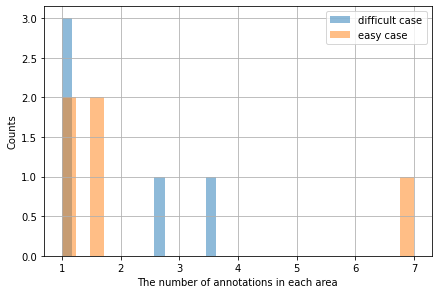

In [ ]:
casediff = pd.read_excel('/content/drive/MyDrive/ML models/sys_4_tt.xlsx',sheet_name='Sheet1',skiprows=1)
case_fp = casediff.loc[:,['Case Name','Case-based difficulty score (cancer)','Location-based difficulty score (cancer)']]
case_fp.dropna(axis=0,inplace=True)
# how to define case diffculty of cancer cases
case_fp['false positive difficulty'] = -case_fp['Case-based difficulty score (cancer)']+case_fp['Location-based difficulty score (cancer)']
case_fp['p_loc'] = pd.qcut(case_fp['false positive difficulty'],3, labels=[0,2,1])
easy_location_cn = case_fp.loc[case_fp['p_loc']==0,:]
diff_location_cn = case_fp.loc[case_fp['p_loc']==1,:]

## get diff and easy
data_cc = pd.read_excel('drive/MyDrive/ML models/Cn_fp_CC_exclude.xlsx')
data_mlo = pd.read_excel('drive/MyDrive/ML models/Cn_fp_MLO_exclude.xlsx')

diff = pd.concat([data_cc.loc[data_cc['caseName'].isin(diff_location_cn['Case Name']),:],
           data_mlo.loc[data_mlo['caseName'].isin(diff_location_cn['Case Name']),:]])
print('The number of fp areas in diff group is :\n',diff['caseName'].value_counts())
group_diff = diff.groupby('caseName')
print('The averaged number of rads in each fp area\n',group_diff['NumRads'].mean())

easy = pd.concat([data_cc.loc[data_cc['caseName'].isin(easy_location_cn['Case Name']),:],
           data_mlo.loc[data_mlo['caseName'].isin(easy_location_cn['Case Name']),:]])
print('The number of fp areas in easy group is :\n',easy['caseName'].value_counts())
group_easy = easy.groupby('caseName')
print('The averaged number of rads in each fp area\n',group_easy['NumRads'].mean())


group_diff['NumRads'].mean().hist(bins=15,alpha=0.5,label='difficult case')
group_easy['NumRads'].mean().hist(bins=25,alpha=0.5,label='easy case')
pyplot.legend(loc='upper right')
pyplot.tight_layout()
pyplot.xlabel('The number of annotations in each area')
pyplot.ylabel('Counts')
pyplot.show()

##### Au normal

The number of fp areas in diff group is :
 MAE     20
GCCB    11
GCAD     8
MBO      7
GCBX     3
MBL      3
GCAI     2
GCBT     2
GCBL     1
LSAF     1
GCCF     1
Name: caseName, dtype: int64
The averaged number of rads in each fp area
 caseName
GCAD    1.000000
GCAI    1.500000
GCBL    1.000000
GCBT    3.500000
GCBX    1.000000
GCCB    1.090909
GCCF    1.000000
LSAF    1.000000
MAE     1.250000
MBL     2.000000
MBO     1.000000
Name: NumRads, dtype: float64
The number of fp areas in easy group is :
 GCBD    8
MAO     6
MAX     5
GCAO    4
GCBA    4
MCD     4
GCAF    3
MAA     3
MCF     3
LSAG    3
LSAQ    2
MAH     2
GCCH    2
GCBS    2
GCAG    1
GCBF    1
LSAH    1
Name: caseName, dtype: int64
The averaged number of rads in each fp area caseName
GCAF    1.333333
GCAG    2.000000
GCAO    1.000000
GCBA    1.000000
GCBD    1.125000
GCBF    1.000000
GCBS    1.000000
GCCH    1.000000
LSAG    1.000000
LSAH    2.000000
LSAQ    1.000000
MAA     1.666667
MAH     1.000000
MAO     1.000000
MAX

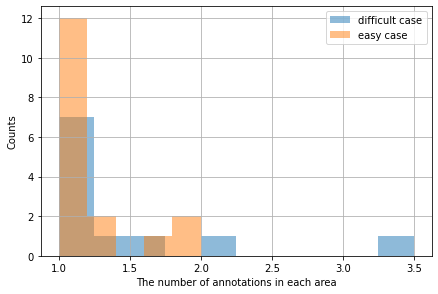

In [ ]:
casediff = pd.read_excel('/content/drive/MyDrive/ML models/sys_4_tt.xlsx',sheet_name='Sheet1',skiprows=1)
case_fp = casediff.loc[:,['Case Name','Difficulty score (normal).1','Location-based difficulty score (cancer).1']]
data = case_fp.copy()
data['p_au'] = pd.qcut(data['Difficulty score (normal).1'],3, labels=[0,2,1])
easy_normal_au = data.loc[data['p_au']==0,:]
diff_normal_au = data.loc[data['p_au']==1,:]

data_cc = pd.read_excel('drive/MyDrive/ML models/Au_fp_CC_exclude.xlsx')
data_mlo = pd.read_excel('drive/MyDrive/ML models/Au_fp_MLO_exclude.xlsx')
diff = pd.concat([data_cc.loc[data_cc['caseName'].isin(diff_normal_cn['Case Name']),:],
           data_mlo.loc[data_mlo['caseName'].isin(diff_normal_cn['Case Name']),:]])
print('The number of fp areas in diff group is :\n',diff['caseName'].value_counts())
group_diff = diff.groupby('caseName')
print('The averaged number of rads in each fp area\n',group_diff['NumRads'].mean())


easy = pd.concat([data_cc.loc[data_cc['caseName'].isin(easy_normal_cn['Case Name']),:],
           data_mlo.loc[data_mlo['caseName'].isin(easy_normal_cn['Case Name']),:]])
print('The number of fp areas in easy group is :\n',easy['caseName'].value_counts())
group_easy = easy.groupby('caseName')
print('The averaged number of rads in each fp area',group_easy['NumRads'].mean())

group_diff['NumRads'].mean().hist(bins=10,alpha=0.5,label='difficult case')
group_easy['NumRads'].mean().hist(bins=5,alpha=0.5,label='easy case')
pyplot.legend(loc='upper right')
pyplot.tight_layout()
pyplot.xlabel('The number of annotations in each area')
pyplot.ylabel('Counts')
pyplot.show()

##### Au location

The number of fp areas in diff group is :
 3.6666666666666665
The averaged number of rads in each fp area
 caseName
GCAN    4.500000
GCBM    2.714286
LSAX    1.000000
Name: NumRads, dtype: float64
The number of fp areas in easy group is :
 4.8
The averaged number of rads in each fp area
 caseName
GCAT    1.00
GCBE    1.20
LSAI    2.00
MAQ     1.25
MCH     1.00
Name: NumRads, dtype: float64


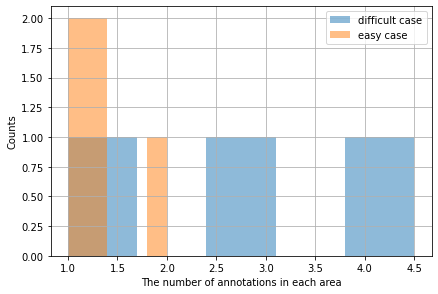

In [ ]:
casediff = pd.read_excel('/content/drive/MyDrive/ML models/sys_4_tt.xlsx',sheet_name='Sheet1',skiprows=1)
case_fp = casediff.loc[:,['Case Name','Case-based difficulty score (cancer).1','Location-based difficulty score (cancer).1']]

case_fp.dropna(axis=0,inplace=True)
# how to define case diffculty of cancer cases
case_fp['false positive difficulty'] = -case_fp['Case-based difficulty score (cancer).1']+case_fp['Location-based difficulty score (cancer).1']
case_fp['p_loc'] = pd.qcut(case_fp['false positive difficulty'],3, labels=[0,2,1])
easy_location_cn = case_fp.loc[case_fp['p_loc']==0,:]
diff_location_cn = case_fp.loc[case_fp['p_loc']==1,:]

## get diff and easy
data_cc = pd.read_excel('drive/MyDrive/ML models/Au_fp_CC_exclude.xlsx')
data_mlo = pd.read_excel('drive/MyDrive/ML models/Au_fp_MLO_exclude.xlsx')

diff = pd.concat([data_cc.loc[data_cc['caseName'].isin(diff_location_cn['Case Name']),:],
           data_mlo.loc[data_mlo['caseName'].isin(diff_location_cn['Case Name']),:]])
print('The number of fp areas in diff group is :\n',diff['caseName'].value_counts().mean())
group_diff = diff.groupby('caseName')
print('The averaged number of rads in each fp area\n',group_diff['NumRads'].mean())

easy = pd.concat([data_cc.loc[data_cc['caseName'].isin(easy_location_cn['Case Name']),:],
           data_mlo.loc[data_mlo['caseName'].isin(easy_location_cn['Case Name']),:]])
print('The number of fp areas in easy group is :\n',easy['caseName'].value_counts().mean())
group_easy = easy.groupby('caseName')
print('The averaged number of rads in each fp area\n',group_easy['NumRads'].mean())


group_diff['NumRads'].mean().hist(bins=5,alpha=0.5,label='difficult case')
group_easy['NumRads'].mean().hist(bins=5,alpha=0.5,label='easy case')
pyplot.legend(loc='upper right')
pyplot.tight_layout()
pyplot.xlabel('The number of annotations in each area')
pyplot.ylabel('Counts')
pyplot.show()

## How is the distribution of fp areas?

In [ ]:
# read in cancer cases, as normals and cancers are analysed separately.
lesion_side = pd.read_excel('/content/drive/MyDrive/ML models/lesion_side.xlsx')
cancers = lesion_side['CaseName'].unique()

In [ ]:
data

,caseName,View,NumRads,Cluster,spacing_1,spacing_2,roi,diffScore,featROI_cn_1,featROI_cn_2,...,featROI_cn_195,featROI_cn_196,featROI_cn_197,featROI_cn_198,featROI_cn_199,featROI_cn_200,featROI_cn_202,featROI_cn_203,indicator,Status
0,GCAA,LCC,2,1,0.05,0.05,1,0.1250,143.883996,39.249841,...,20.057215,26.134693,59.474247,21.231247,46.881954,0.575433,20780.813976,4023.824114,0,normal
1,GCAA,RCC,2,1,0.05,0.05,7,0.1250,149.013014,38.954566,...,19.019608,24.181108,56.713493,19.855315,44.621147,0.520666,18508.897374,2753.595286,0,normal
2,GCAB,LCC,1,1,0.05,0.05,11,0.0625,119.104902,47.841025,...,16.584787,20.718681,55.012939,17.135944,38.826006,0.544632,21861.284712,6368.020455,0,normal
3,GCAB,RCC,1,2,0.05,0.05,14,0.0625,111.439529,40.812289,...,22.122527,29.029943,68.725940,23.618840,52.028994,0.717060,13660.221301,3042.308170,0,normal
4,GCAB,RCC,1,3,0.05,0.05,15,0.0625,83.193099,35.030167,...,21.909176,27.711919,71.384165,22.616591,50.248488,0.724198,9040.951609,2536.878791,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,MBM,RMLO,1,4,0.10,0.10,298,0.0625,89.404607,31.851951,...,29.333374,80.368113,56.047848,48.625933,87.010287,0.885000,7265.167446,2215.753218,0,non lesion
142,MBM,RMLO,1,1,0.10,0.10,296,0.0625,94.170769,31.667453,...,37.230747,100.915113,70.776646,61.353506,112.493228,0.982643,7327.503452,2016.986435,0,non lesion
143,MBM,RMLO,1,3,0.10,0.10,297,0.0625,114.783312,42.126302,...,37.961961,104.105945,72.990828,63.421050,115.128088,0.913676,9885.887315,3040.100985,0,non lesion
144,MBM,RMLO,1,4,0.10,0.10,298,0.0625,89.404607,31.851951,...,29.333374,80.368113,56.047848,48.625933,87.010287,0.885000,7265.167446,2215.753218,0,non lesion


#### Chinese normlas + lesion


[1. 2. 2.]
217
102


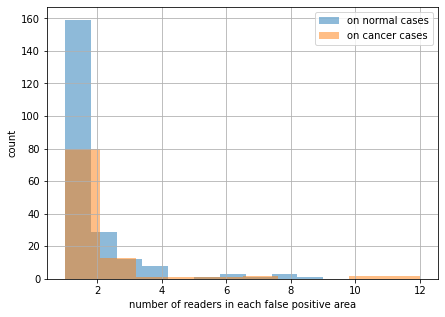

In [ ]:
data_cc = pd.read_excel('drive/MyDrive/ML models/Cn_fp_CC_exclude.xlsx')
# data_cc = data_cc.loc[~data_cc['caseName'].isin(cancers),:]
data_mlo = pd.read_excel('drive/MyDrive/ML models/Cn_fp_MLO_exclude.xlsx')
# data_mlo = data_mlo.loc[~data_mlo['caseName'].isin(cancers),:]
data = pd.concat([data_cc,data_mlo])
print(np.percentile(data['NumRads'], [50,75,80]))

data.drop(columns ='featROI_cn_201' , inplace = True)
data_normal = data.loc[~data['caseName'].isin(cancers),:]
data_cancer = data.loc[data['caseName'].isin(cancers),:]
print(len(data_normal))
print(len(data_cancer))
fig = pyplot.figure(figsize=[7,5])
ax = pyplot.subplot(111)
ax.hist(data_normal['NumRads'],label='on normal cases', alpha=0.5)
ax.hist(data_cancer['NumRads'],label='on cancer cases', alpha=0.5)

# set the basic properties
ax.set_xlabel('number of readers in each false positive area')
ax.set_ylabel('count')
# set the grid on
ax.legend()
ax.grid('off')
pyplot.show()

In [ ]:
np.sum(data_normal['NumRads']==1)/len(data_normal)

0.7327188940092166

In [ ]:
print(np.percentile(data_normal['NumRads'],[0,25,50,75,85,90,100]))
print(np.percentile(data_cancer['NumRads'],[0,25,50,75,85,90,100]))
print(np.percentile(pd.concat([data_normal['NumRads'],data_cancer['NumRads']]),[0,25,50,75,85,90,100]))

[1. 1. 1. 2. 2. 3. 9.]
[ 1.  1.  1.  2.  3.  3. 12.]
[ 1.  1.  1.  2.  3.  3. 12.]


In [ ]:
print(np.percentile(data_normal['NumRads'][data_normal['NumRads']!=1],[0,25,50,75,100]))
print(np.percentile(data_cancer['NumRads'][data_cancer['NumRads']!=1],[0,25,50,75,100]))
print(np.percentile(pd.concat([data_normal['NumRads'][data_normal['NumRads']!=1],data_cancer['NumRads'][data_cancer['NumRads']!=1]]),[0,25,50,75,100]))

[2.   2.   2.   3.75 8.  ]
[ 2.    2.    3.    3.75 12.  ]
[ 2.    2.    3.    3.75 12.  ]


In [ ]:
print(np.sum(data_normal['NumRads']>=4))
print(np.sum(data_cancer['NumRads']>=4))
print(np.sum(pd.concat([data_normal['NumRads'][data_normal['NumRads']!=1],data_cancer['NumRads'][data_cancer['NumRads']!=1]])>=4))

13
7
20


#### Australian normals + lesion

[1.  1.  1.  1.9]
142
93


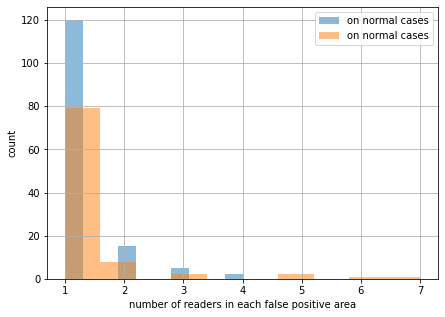

In [ ]:
data_cc = pd.read_excel('drive/MyDrive/ML models/Au_fp_CC_exclude.xlsx')
data_mlo = pd.read_excel('drive/MyDrive/ML models/Au_fp_MLO_exclude.xlsx')

data = pd.concat([data_cc,data_mlo])
data.drop(columns ='featROI_au_201' , inplace = True)
print(np.percentile(data['NumRads'], [50,75,80,85]))

data_normal = data.loc[~data['caseName'].isin(cancers),:]
data_cancer = data.loc[data['caseName'].isin(cancers),:]
print(len(data_normal))
print(len(data_cancer))
fig = pyplot.figure(figsize=[7,5])
ax = pyplot.subplot(111)
ax.hist(data_normal['NumRads'],label='on normal cases', alpha=0.5)
ax.hist(data_cancer['NumRads'],label='on normal cases', alpha=0.5)

# set the basic properties
ax.set_xlabel('number of readers in each false positive area')
ax.set_ylabel('count')
# set the grid on
ax.legend()
ax.grid('off')
pyplot.show()

In [ ]:
np.sum(data_normal['NumRads']==1)/len(data_normal)

0.8450704225352113

In [ ]:
print(np.percentile(data_normal['NumRads'],[0,25,50,75,85,90,100]))
print(np.percentile(data_cancer['NumRads'],[0,25,50,75,85,90,100]))
print(np.percentile(pd.concat([data_normal['NumRads'],data_cancer['NumRads']]),[0,25,50,75,85,90,100]))

[1.   1.   1.   1.   1.85 2.   4.  ]
[1.  1.  1.  1.  1.2 2.  7. ]
[1.  1.  1.  1.  1.9 2.  7. ]


In [ ]:
print(np.percentile(data_normal['NumRads'][data_normal['NumRads']!=1],[0,25,50,75,100]))
print(np.percentile(data_cancer['NumRads'][data_cancer['NumRads']!=1],[0,25,50,75,100]))
print(np.percentile(pd.concat([data_normal['NumRads'][data_normal['NumRads']!=1],data_cancer['NumRads'][data_cancer['NumRads']!=1]]),[0,25,50,75,100]))

[2. 2. 2. 3. 4.]
[2.  2.  2.  4.5 6. ]
[2. 2. 2. 3. 6.]


In [ ]:
print(np.sum(data_normal['NumRads']>=3))
print(np.sum(data_cancer['NumRads']>=5))
print(np.sum(pd.concat([data_normal['NumRads'][data_normal['NumRads']!=1],data_cancer['NumRads'][data_cancer['NumRads']!=1]])>=3))

6
3
11


In [ ]:
# using clustering (unsupervised) to see if there are any clusters?
from sklearn.cluster import KMeans
k = 5
kmeans_au = KMeans(n_clusters=k)
#data_explore.drop('Rads',axis=1, inplace=True)
y_pred = kmeans_au.fit_predict(data_explore)

In [ ]:
Au_clustering = pd.DataFrame({'Rads': data['Rads'].to_numpy(),
                              'predicted_class': y_pred,
                              'casename':data['CaseName_names'],
                              'view':data['View']})
print(Au_clustering.loc[Au_clustering.predicted_class==0,:].casename.unique())
print(Au_clustering.loc[Au_clustering.predicted_class==1,:].casename.unique())
print(Au_clustering.loc[Au_clustering.predicted_class==2,:].casename.unique())
print(Au_clustering.loc[Au_clustering.predicted_class==3,:].casename.unique())
print(Au_clustering.loc[Au_clustering.predicted_class==4,:].casename.unique())

['GCAA' 'GCAD' 'GCAF' 'GCAG' 'GCAI' 'GCAJ' 'GCAO' 'GCAZ' 'GCBA' 'GCBD'
 'GCBF' 'GCBH' 'GCBL' 'GCBS' 'GCBX' 'GCCH' 'LSAB' 'LSAC' 'LSAF' 'LSAG'
 'MAA' 'MAH' 'MAO' 'MAX' 'MCD' 'GCAB' 'GCBT' 'GCBZ' 'GCCB' 'LSAJ']
['GCAF' 'GCAI' 'GCAZ' 'GCBH' 'GCBL' 'GCBZ' 'LSAG' 'LSAJ' 'LSAM' 'MAE'
 'MAO' 'MCD' 'MCF' 'GCBD' 'LSAB']
['LSAF' 'MBL' 'GCAZ' 'GCCF' 'MAE' 'MBO']
['GCAJ' 'GCBS' 'GCBT' 'GCBX' 'GCCB' 'LSAC' 'LSAG' 'LSAH' 'LSAQ' 'MAA'
 'MAH' 'MAO' 'MBL' 'MBO' 'MCF' 'GCAD' 'GCAI' 'GCAO' 'GCBH' 'GCBY' 'LSAB'
 'MAE' 'MAX' 'MCD']
['LSAM']


## Machine learning

#### Normal false positve areas without omitting

In [ ]:
# read in cancer cases, as normals and cancers are analysed separately.
lesion_side = pd.read_excel('/content/drive/MyDrive/ML models/lesion_side.xlsx')
cancers = lesion_side['CaseName'].unique()

In [ ]:
# get dataset for non-omiting dataset
def get_au_data(path):
  data = pd.read_excel(path)
  #data = data.loc[~data['caseName'].isin(cancers),:]
  data.drop(columns ='featROI_au_201' , inplace = True)
  d = data.copy()
  d['p'] = pd.cut(data.Rads, bins = [1,2,data.Rads.describe()['max']], labels=[0,1])
  d.dropna(subset = ['p'],inplace=True)
  y = d['p'].to_numpy().reshape(-1,1)
  X = d.loc[:,'featROI_au_  1':'featROI_au_203'].to_numpy()
  print('The shape of sample size * features :',X.shape)
  print('Size of difficult and easy samples',(d['p']==1).sum(),(d['p']==0).sum())
  over = SMOTE(sampling_strategy="minority",random_state=2,k_neighbors=5)
  X,y = over.fit_resample(X,y)
  return X,y


def get_cn_data(path):
  data = pd.read_excel(path)
  data.drop(columns ='featROI_cn_201' , inplace = True)
  d = data.copy()
  d['p'] = pd.cut(data.Rads, bins = [1,3,data.Rads.describe()['max']], labels=[0,1])
  d.dropna(subset = ['p'],inplace=True)
  X = d.loc[:,'featROI_cn_  1':'featROI_cn_203'].to_numpy()
  print('The shape of sample size * features :',X.shape)
  y = d['p'].to_numpy().reshape(-1,1)
  print('Size of difficult and easy samples',(d['p']==1).sum(),(d['p']==0).sum())
  over = SMOTE(sampling_strategy="minority",random_state=2,k_neighbors=5)
  X,y = over.fit_resample(X,y)
  return X,y

#### Normal cases with data omitting

In [ ]:
# read in cancer cases, as normals and cancers are analysed separately.
lesion_side = pd.read_excel('/content/drive/MyDrive/ML models/lesion_side.xlsx')
cancers = lesion_side['CaseName'].unique()

In [ ]:
# get dataset for omiting dataset
# all cases, including cancers
def get_au_data(path):
  data = pd.read_excel(path)
  #data = data.loc[~data['caseName'].isin(cancers),:]
  data.drop(columns ='featROI_au_201' , inplace = True)
  d = data.copy()
  d['p'] = pd.cut(data.NumRads, bins = [0,1,data.NumRads.describe()['max']], labels=[0,1])
  #d['p'] = pd.cut(data.NumRads, bins = [0,2,data.NumRads.describe()['max']], labels=[0,1])
  d.dropna(axis=0,inplace=True)
  y = d['p'].to_numpy().reshape(-1,1)
  X = d.loc[:,'featROI_au_1':'featROI_au_203'].to_numpy()
  print('The shape of sample size * features :',X.shape)
  print('Size of difficult and easy samples',(d['p']==1).sum(),(d['p']==0).sum())

  return X,y

def get_cn_data(path):
  data = pd.read_excel(path)
  #data = data.loc[~data['caseName'].isin(cancers),:]
  data.drop(columns ='featROI_cn_201' , inplace = True)
  d = data.copy()
  d['p'] = pd.cut(data.NumRads, bins = [0,1,data.NumRads.describe()['max']], labels=[0,1])
  #d['p'] = pd.cut(data.NumRads, bins = [0,3,data.NumRads.describe()['max']], labels=[0,1])
  d.dropna(axis=0,inplace=True)
  X = d.loc[:,'featROI_cn_1':'featROI_cn_203'].to_numpy()
  print('The shape of sample size * features :',X.shape)
  y = d['p'].to_numpy().reshape(-1,1)
  print('Size of difficult and easy samples',(d['p']==1).sum(),(d['p']==0).sum())

  return X,y

### Get feature importance with random forest (class_weight)

In [ ]:
# check version number
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
print(imblearn.__version__)

over = SMOTE()
under = RandomUnderSampler(sampling_strategy=0.5)

0.10.1


In [ ]:
# check the label of Chinese CC
path = 'drive/MyDrive/ML models/Cn_fp_CC_exclude.xlsx'
Cn_CC = pd.read_excel(path)
Cn_CC

,caseName,View,NumRads,Cluster,spacing_1,spacing_2,roi,diffScore,featROI_cn_1,featROI_cn_2,...,featROI_cn_196,featROI_cn_197,featROI_cn_198,featROI_cn_199,featROI_cn_200,featROI_cn_201,featROI_cn_202,featROI_cn_203,indicator,Status
0,GCAA,LCC,2,1,0.05,0.05,1,0.1250,143.883996,39.249841,...,26.134693,59.474247,21.231247,46.881954,0.575433,NaN,20780.813976,4023.824114,0,normal
1,GCAA,RCC,2,1,0.05,0.05,7,0.1250,149.013014,38.954566,...,24.181108,56.713493,19.855315,44.621147,0.520666,NaN,18508.897374,2753.595286,0,normal
2,GCAB,LCC,1,1,0.05,0.05,11,0.0625,119.104902,47.841025,...,20.718681,55.012939,17.135944,38.826006,0.544632,-1.395588,21861.284712,6368.020455,0,normal
3,GCAB,RCC,1,2,0.05,0.05,14,0.0625,111.439529,40.812289,...,29.029943,68.725940,23.618840,52.028994,0.717060,NaN,13660.221301,3042.308170,0,normal
4,GCAB,RCC,1,3,0.05,0.05,15,0.0625,83.193099,35.030167,...,27.711919,71.384165,22.616591,50.248488,0.724198,NaN,9040.951609,2536.878791,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,MAY,LCC,1,3,0.10,0.10,275,0.0625,126.205920,42.950367,...,81.055425,85.525678,54.527392,106.356408,0.770379,NaN,10410.920372,2344.811080,0,non lesion
169,MAY,LCC,3,1,0.10,0.10,274,0.1875,74.306508,44.364277,...,58.535324,64.939968,39.069762,77.457723,0.627681,NaN,6401.982623,2671.503229,0,non lesion
170,MBM,LCC,1,2,0.10,0.10,290,0.0625,81.796305,35.916876,...,58.815794,50.500122,35.399806,65.623262,0.713361,NaN,8051.669051,2811.563889,0,lesionside
171,MBM,LCC,2,1,0.10,0.10,289,0.1250,66.158967,25.816016,...,52.850357,50.248074,32.705115,63.424612,0.743093,NaN,6118.610466,1631.395765,0,lesionside


In [ ]:
path = 'drive/MyDrive/ML models/Cn_fp_CC_exclude.xlsx'
#path = 'drive/MyDrive/ML models/Cn_fp_CC.xlsx'
X,y = get_cn_data(path)


cv_outer = LeaveOneOut()
features = dict()
Yhat_proba,Yhat = list(),list()
Y_true = []
Best_inner_score = []
row = 0
for train_ix, test_ix in cv_outer.split(X):
  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  print(train_ix)
  clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1, random_state=4) #,class_weight='balanced_subsample')
  pipeline = Pipeline([('over',over),
                      ('s', StandardScaler()),
                     ('var',VarianceThreshold(threshold=1)),
                      ('model',clf)])
  space = {"model__n_estimators": [100,250,500,1000]}

  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipeline, space, scoring='roc_auc',n_jobs = -1, cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train.ravel())
  best_model = result.best_estimator_
  yhat_proba = best_model.predict_proba(X_test)[:,1]
  Yhat_proba.append(yhat_proba[0])
  yhat = best_model.predict(X_test)
  Yhat.append(yhat[0])
  Y_true.append(y_test[0])

  print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
  Best_inner_score.append(result.best_score_)

  feature_names = result.best_estimator_.named_steps['var'].get_support(indices=True)
  print('The number of remained feautes after variance check: ', len(feature_names))
  # print(feature_names)
  result_importance = result.best_estimator_.named_steps['model'].feature_importances_
  forest_importances = pd.Series(result_importance, index=feature_names)
  Feats = np.argsort(forest_importances)[::-1][:10]
  features[row] = Feats
  row+=1

# Print TP and FP
print("Y_true",Y_true)
print("Yhat_proba", Yhat_proba)


# Calculate roc_auc on the hold out dataset
AUC_score = roc_auc_score(Y_true, Yhat_proba)
Accuracy = accuracy_score(Y_true,Yhat)
print('auc: %.3f' % AUC_score)
print("Accuracy: ", Accuracy)
print('precision', precision_score(Y_true,Yhat))
print("recall",recall_score(Y_true,Yhat))
print('f1 metrics',f1_score(Y_true,Yhat))
print('The average best inner score is {}, the standard deviation of the scores is {}'.format(mean(Best_inner_score), std(Best_inner_score)))
print(Y_true)
print(Yhat_proba)

cm1 = confusion_matrix(Y_true,Yhat)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

# check the important features
Dict = {}
for key in sorted(features):
    for num in features[key]:
        if num not in Dict:
            Dict[num] = 1
        else:
            Dict[num]+=1
KEY = []
for key in sorted(Dict):
  print(key,':',Dict[key])

print('The top 5 frequently selected features',sorted(Dict, key=Dict.get, reverse=True)[:5])

The shape of sample size * features : (173, 202)
Size of difficult and easy samples 48 125
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172]
>est=0.826, cfg={'model__n_estimators': 1000}
The number of remained feautes after variance check:  101
[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26 

In [ ]:
# bootstrap
# get confidence interval
n_bootstraps = 2000
rng_seed = 14  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(Yhat_proba), len(Yhat_proba))
    if len(np.unique(np.array(Y_true)[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(np.array(Y_true)[indices], np.array(Yhat_proba)[indices])
    bootstrapped_scores.append(score)
#     print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))


Confidence interval for the score: [0.802 - 0.918]


In [ ]:
path = 'drive/MyDrive/ML models/Cn_fp_MLO_exclude.xlsx'
# path = 'drive/MyDrive/ML models/Cn_fp_MLO.xlsx'

X,y = get_cn_data(path)

cv_outer = LeaveOneOut()
features = dict()
Yhat_proba,Yhat = list(),list()
Y_true = []
Best_inner_score = []
row = 0
for train_ix, test_ix in cv_outer.split(X):
  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1, random_state=4,class_weight='balanced_subsample')
  pipeline = Pipeline([('over',over),
                      #('under',under),
                      ('s', StandardScaler()),
                     ('var',VarianceThreshold(threshold=1)),
                      #('pca',PCA(0.95)),
                      ('model',clf)])
  space = {"model__n_estimators": [100,250,500,1000]}

  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipeline, space, scoring='roc_auc',n_jobs = -1, cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train.ravel())
  best_model = result.best_estimator_
  yhat_proba = best_model.predict_proba(X_test)[:,1]
  Yhat_proba.append(yhat_proba[0])
  yhat = best_model.predict(X_test)
  Yhat.append(yhat[0])
  Y_true.append(y_test[0])

  print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
  Best_inner_score.append(result.best_score_)

  feature_names = result.best_estimator_.named_steps['var'].get_support(indices=True)
  print('The number of remained feautes after variance check: ', len(feature_names))
  # print(feature_names)
  result_importance = result.best_estimator_.named_steps['model'].feature_importances_
  forest_importances = pd.Series(result_importance, index=feature_names)
  Feats = np.argsort(forest_importances)[::-1][:10]
  features[row] = Feats
  row+=1

# Calculate roc_auc on the hold out dataset
AUC_score = roc_auc_score(Y_true, Yhat_proba)
Accuracy = accuracy_score(Y_true,Yhat)
print('auc: %.3f' % AUC_score)
print("Accuracy: ", Accuracy)
print('precision', precision_score(Y_true,Yhat))
print("recall",recall_score(Y_true,Yhat))
print('f1 metrics',f1_score(Y_true,Yhat))
print('The average best inner score is {}, the standard deviation of the scores is {}'.format(mean(Best_inner_score), std(Best_inner_score)))
print(Y_true)
print(Yhat_proba)

cm1 = confusion_matrix(Y_true,Yhat)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

# check the important features
Dict = {}
for key in sorted(features):
    for num in features[key]:
        if num not in Dict:
            Dict[num] = 1
        else:
            Dict[num]+=1
KEY = []
for key in sorted(Dict):
  print(key,':',Dict[key])

print('The top 5 frequently selected features',sorted(Dict, key=Dict.get, reverse=True)[:5])

The shape of sample size * features : (146, 202)
Size of difficult and easy samples 42 104
>est=0.817, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  93
>est=0.820, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  93
>est=0.830, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  91
>est=0.835, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  95
>est=0.815, cfg={'model__n_estimators': 1000}
The number of remained feautes after variance check:  93
>est=0.819, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  97
>est=0.823, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  98
>est=0.835, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  91
>est=0.855, cfg={'model__n_estimators': 100}
The number of remained feautes after variance c

In [ ]:
# get confidence interval
n_bootstraps = 2000
rng_seed = 14  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(Yhat_proba), len(Yhat_proba))
    if len(np.unique(np.array(Y_true)[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(np.array(Y_true)[indices], np.array(Yhat_proba)[indices])
    bootstrapped_scores.append(score)
#     print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.749 - 0.893]


In [ ]:
path = 'drive/MyDrive/ML models/Au_fp_CC_exclude.xlsx'
# path = 'drive/MyDrive/ML models/Au_fp_CC.xlsx'
X,y = get_au_data(path)

cv_outer = LeaveOneOut()
features = dict()
Yhat_proba,Yhat = list(),list()
Y_true = []
Best_inner_score = []
row = 0
for train_ix, test_ix in cv_outer.split(X):
  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1, random_state=4,class_weight='balanced_subsample')
  pipeline = Pipeline([('over',over),
                      ('s', StandardScaler()),
                     ('var',VarianceThreshold(threshold=1)),
                      ('model',clf)])
  space = {"model__n_estimators": [100,250,500,1000]}

  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipeline, space, scoring='roc_auc',n_jobs = -1, cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train.ravel())
  best_model = result.best_estimator_
  yhat_proba = best_model.predict_proba(X_test)[:,1]
  Yhat_proba.append(yhat_proba[0])
  yhat = best_model.predict(X_test)
  Yhat.append(yhat[0])
  Y_true.append(y_test[0])

  print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
  Best_inner_score.append(result.best_score_)

  feature_names = result.best_estimator_.named_steps['var'].get_support(indices=True)
  print('The number of remained feautes after variance check: ', len(feature_names))
  # print(feature_names)
  result_importance = result.best_estimator_.named_steps['model'].feature_importances_
  forest_importances = pd.Series(result_importance, index=feature_names)
  Feats = np.argsort(forest_importances)[::-1][:10]
  features[row] = Feats
  row+=1

# Calculate roc_auc on the hold out dataset
AUC_score = roc_auc_score(Y_true, Yhat_proba)
Accuracy = accuracy_score(Y_true,Yhat)
print('auc: %.3f' % AUC_score)
print("Accuracy: ", Accuracy)
print('precision', precision_score(Y_true,Yhat))
print("recall",recall_score(Y_true,Yhat))
print('f1 metrics',f1_score(Y_true,Yhat))
print('The average best inner score is {}, the standard deviation of the scores is {}'.format(mean(Best_inner_score), std(Best_inner_score)))
print(Y_true)
print(Yhat)
print(Yhat_proba)

cm1 = confusion_matrix(Y_true,Yhat)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

# check the important features
Dict = {}
for key in sorted(features):
    for num in features[key]:
        if num not in Dict:
            Dict[num] = 1
        else:
            Dict[num]+=1
KEY = []
for key in sorted(Dict):
  print(key,':',Dict[key])

print('The top 5 frequently selected features',sorted(Dict, key=Dict.get, reverse=True)[:5])

The shape of sample size * features : (96, 202)
Size of difficult and easy samples 20 76
>est=0.661, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  82
>est=0.645, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  85
>est=0.639, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  72
>est=0.622, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  91
>est=0.641, cfg={'model__n_estimators': 1000}
The number of remained feautes after variance check:  94
>est=0.629, cfg={'model__n_estimators': 1000}
The number of remained feautes after variance check:  100
>est=0.643, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  92
>est=0.674, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  99
>est=0.665, cfg={'model__n_estimators': 250}
The number of remained feautes after variance c

In [ ]:
# get bootstrap
# get confidence interval
n_bootstraps = 2000
rng_seed = 14  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(Yhat_proba), len(Yhat_proba))
    if len(np.unique(np.array(Y_true)[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(np.array(Y_true)[indices], np.array(Yhat_proba)[indices])
    bootstrapped_scores.append(score)
#     print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.489 - 0.756]


In [ ]:
path = 'drive/MyDrive/ML models/Au_fp_MLO_exclude.xlsx'
# path = 'drive/MyDrive/ML models/Au_fp_MLO.xlsx'
X,y = get_au_data(path)

# model
cv_outer = LeaveOneOut()
features = dict()
Yhat_proba,Yhat = list(),list()
Y_true = []
Best_inner_score = []
row = 0
for train_ix, test_ix in cv_outer.split(X):
  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1, random_state=4,class_weight='balanced_subsample')
  pipeline = Pipeline([('over',over),
                      #('under',under),
                      ('s', StandardScaler()),
                     ('var',VarianceThreshold(threshold=1)),
                      #('pca',PCA(0.95)),
                      ('model',clf)])
  space = {"model__n_estimators": [100,250,500,1000]}

  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipeline, space, scoring='roc_auc',n_jobs = -1, cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train.ravel())
  best_model = result.best_estimator_
  yhat_proba = best_model.predict_proba(X_test)[:,1]
  Yhat_proba.append(yhat_proba[0])
  yhat = best_model.predict(X_test)
  Yhat.append(yhat[0])
  Y_true.append(y_test[0])

  print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
  Best_inner_score.append(result.best_score_)

  feature_names = result.best_estimator_.named_steps['var'].get_support(indices=True)
  print('The number of remained feautes after variance check: ', len(feature_names))
  # print(feature_names)
  result_importance = result.best_estimator_.named_steps['model'].feature_importances_
  forest_importances = pd.Series(result_importance, index=feature_names)
  Feats = np.argsort(forest_importances)[::-1][:10]
  features[row] = Feats
  row+=1

# Calculate roc_auc on the hold out dataset
AUC_score = roc_auc_score(Y_true, Yhat_proba)
Accuracy = accuracy_score(Y_true,Yhat)
print('auc: %.3f' % AUC_score)
print("Accuracy: ", Accuracy)
print('precision', precision_score(Y_true,Yhat))
print("recall",recall_score(Y_true,Yhat))
print('f1 metrics',f1_score(Y_true,Yhat))
print('The average best inner score is {}, the standard deviation of the scores is {}'.format(mean(Best_inner_score), std(Best_inner_score)))
print(Y_true)
print(Yhat_proba)

cm1 = confusion_matrix(Y_true,Yhat)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

# check the important features
Dict = {}
for key in sorted(features):
    for num in features[key]:
        if num not in Dict:
            Dict[num] = 1
        else:
            Dict[num]+=1
KEY = []
for key in sorted(Dict):
  print(key,':',Dict[key])

print('The top 5 frequently selected features',sorted(Dict, key=Dict.get, reverse=True)[:5])

The shape of sample size * features : (139, 202)
Size of difficult and easy samples 16 123
>est=0.745, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  99
>est=0.780, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  94
>est=0.649, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  95
>est=0.674, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  86
>est=0.649, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  93
>est=0.666, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  101
>est=0.758, cfg={'model__n_estimators': 1000}
The number of remained feautes after variance check:  90
>est=0.682, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  83
>est=0.670, cfg={'model__n_estimators': 100}
The number of remained feautes after variance 

In [ ]:
# get bootstrap
# get confidence interval
n_bootstraps = 2000
rng_seed = 14  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(Yhat_proba), len(Yhat_proba))
    if len(np.unique(np.array(Y_true)[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(np.array(Y_true)[indices], np.array(Yhat_proba)[indices])
    bootstrapped_scores.append(score)
#     print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.620 - 0.861]


## Analyse significant features

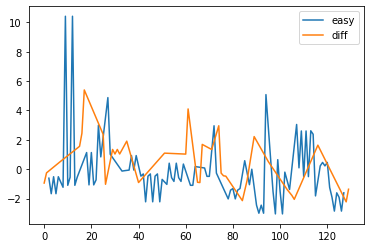

easy median -0.5095530245480051 easy interquatile 1.7828504541252446
diff median 0.5416019914561998 diff interquatile 2.504484001182117
mannwhitneyu MannwhitneyuResult(statistic=1190.0, pvalue=0.013227893850478093)


In [ ]:
path ='drive/MyDrive/ML models/Cn_fp_CC_exclude.xlsx'
data = pd.read_excel(path)
data = data.loc[~data['caseName'].isin(cancers),:]
data.drop(columns ='featROI_cn_201' , inplace = True)
data_sig = data.loc[:,'featROI_cn_53':'featROI_cn_57']

scaler = StandardScaler()
data_sig_scale = scaler.fit_transform(data_sig)
feat_cn_cc = PCA(n_components=0.95)
data_sig_scale_first_component = feat_cn_cc.fit_transform(data_sig_scale)

df_component = pd.DataFrame(data_sig_scale_first_component,columns=['0','1'])
df_component.insert(0,'NumRads',data['NumRads'])
easy = df_component.loc[df_component['NumRads']==1,'0']
diff = df_component.loc[df_component['NumRads']>=2,'0']

easy.plot(label='easy')
diff.plot(label='diff')
pyplot.legend()
pyplot.show()

print('easy median', easy.median(),'easy interquatile',np.percentile(easy,75)-np.percentile(easy,25) )
print('diff median', diff.median(),'diff interquatile',np.percentile(diff,75)-np.percentile(diff,25) )
print('mannwhitneyu', mannwhitneyu(easy,diff))
print(feat_cn_cc.explained_variance_ratio_)

(87, 1)


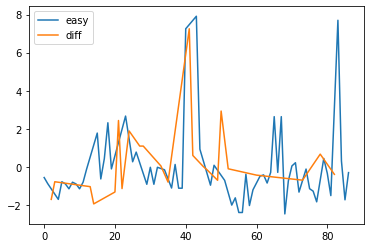

easy median -0.6051572511115719 easy interquatile 1.223452978092572
diff median -0.15735656576359178 diff interquatile 1.671844116388637
mannwhitneyu MannwhitneyuResult(statistic=592.0, pvalue=0.1672033386124303)
[0.8210699]


In [ ]:
path ='drive/MyDrive/ML models/Cn_fp_MLO_exclude.xlsx'
data = pd.read_excel(path)
data = data.loc[~data['caseName'].isin(cancers),:]
data.drop(columns ='featROI_cn_201' , inplace = True)
data_sig = data.loc[:,['featROI_cn_46','featROI_cn_47','featROI_cn_49','featROI_cn_50','featROI_cn_51']]

scaler_mlo_cn = StandardScaler()
data_sig_scale = scaler_mlo_cn.fit_transform(data_sig)
feat_cn_mlo = PCA(n_components=0.95)
data_sig_scale_first_component = feat_cn_mlo.fit_transform(data_sig_scale)
print(data_sig_scale_first_component.shape)

df_component = pd.DataFrame(data_sig_scale_first_component,columns=['0','1'])
df_component.insert(0,'NumRads',data['NumRads'])
easy = df_component.loc[df_component['NumRads']==1,'0']
diff = df_component.loc[df_component['NumRads']>=2,'0']

easy.plot(label='easy')
diff.plot(label='diff')
pyplot.legend()
pyplot.show()

print('easy median', easy.median(),'easy interquatile',np.percentile(easy,75)-np.percentile(easy,25) )
print('diff median', diff.median(),'diff interquatile',np.percentile(diff,75)-np.percentile(diff,25) )
print('mannwhitneyu', mannwhitneyu(easy,diff))
print(feat_cn_mlo.explained_variance_ratio_)

(67, 2)


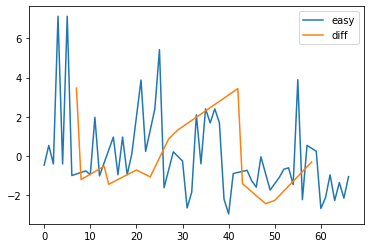

easy median 0.041584406032341335 easy interquatile 2.1904024463069662 2.259786778416017
diff median -0.17273522505741787 diff interquatile 2.284841684082841 1.926688241393969
mannwhitneyu MannwhitneyuResult(statistic=372.0, pvalue=0.7451496684855998)
studnet t Ttest_indResult(statistic=0.31503483127350274, pvalue=0.7537443478979843)
[0.94232394 0.03953404]


In [ ]:
path ='drive/MyDrive/ML models/Au_fp_CC_exclude.xlsx'
data = pd.read_excel(path)
data = data.loc[~data['caseName'].isin(cancers),:]
data.drop(columns ='featROI_au_201' , inplace = True)
data_sig = data.loc[:,['featROI_au_51','featROI_au_53','featROI_au_54','featROI_au_55','featROI_au_56']]

scaler_cc_au = StandardScaler()
data_sig_scale = scaler_cc_au.fit_transform(data_sig)
feat_au_cc = PCA(n_components=0.95)
data_sig_scale_first_component = feat_au_cc.fit_transform(data_sig_scale)
print(data_sig_scale_first_component.shape)

df_component = pd.DataFrame(data_sig_scale_first_component,columns=['0','1'])
df_component.insert(0,'NumRads',data['NumRads'])
easy = df_component.loc[df_component['NumRads']==1,'0']
diff = df_component.loc[df_component['NumRads']>=2,'0']

easy.plot(label='easy')
diff.plot(label='diff')
pyplot.legend()
pyplot.show()

print('easy median', easy.mean(),'easy interquatile',np.percentile(easy,75)-np.percentile(easy,25) , easy.std())
print('diff median', diff.mean(),'diff interquatile',np.percentile(diff,75)-np.percentile(diff,25),diff.std() )
print('mannwhitneyu', mannwhitneyu(easy,diff))
print('studnet t',ttest_ind(easy, diff))
print(feat_au_cc.explained_variance_ratio_)

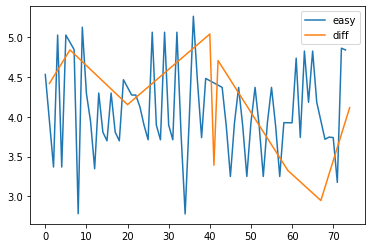

easy mean 4.078519663331262 easy interquatile 0.6876912205515975 std 0.5842540012432078
diff mean 4.105160775436995 diff interquatile 1.3168074662844749 std 0.5842540012432078
mannwhitneyu MannwhitneyuResult(statistic=280.0, pvalue=0.7878306712347684)
studnet t Ttest_indResult(statistic=-0.1243609697868739, pvalue=0.9013712839291135)
[0.72965402 0.24602177]


In [ ]:
path ='drive/MyDrive/ML models/Au_fp_MLO_exclude.xlsx'
data = pd.read_excel(path)
data = data.loc[~data['caseName'].isin(cancers),:]
data.drop(columns ='featROI_au_201' , inplace = True)
data_sig = data.loc[:,['featROI_au_46','featROI_au_47','featROI_au_49','featROI_au_50','featROI_au_51']]

# scaler_mlo_au = StandardScaler()
# data_sig_scale = scaler_mlo_au.fit_transform(data_sig)
# feat_au_mlo = PCA(n_components=0.95)
# data_sig_scale_first_component = feat_au_mlo.fit_transform(data_sig_scale)
# print(data_sig_scale_first_component.shape)

# df_component = pd.DataFrame(data_sig_scale_first_component,columns=['0','1'])
# df_component.insert(0,'NumRads',data['NumRads'])
# easy = df_component.loc[df_component['NumRads']==1,'0']
# diff = df_component.loc[df_component['NumRads']>=2,'0']
data_sig.insert(0,'NumRads',data['NumRads'])
easy = data_sig.loc[data_sig['NumRads']==1,'featROI_au_46']
diff = data_sig.loc[data_sig['NumRads']>=2,'featROI_au_46']


easy.plot(label='easy')
diff.plot(label='diff')
pyplot.legend()
pyplot.show()

print('easy mean', easy.mean(),'easy interquatile',np.percentile(easy,75)-np.percentile(easy,25),'std',easy.std())
print('diff mean', diff.mean(),'diff interquatile',np.percentile(diff,75)-np.percentile(diff,25),'std',easy.std() )
print('mannwhitneyu', mannwhitneyu(easy,diff))
print('studnet t',ttest_ind(easy, diff))
print(feat_au_mlo.explained_variance_ratio_)

### Get feature importance using bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import geometric_mean_score

In [ ]:
path = 'drive/MyDrive/ML models/Cn_fp_CC_exclude.xlsx'
X,y = get_cn_data(path)

# model
cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=4)

outer_acc,outer_auc,outer_f1 = list(), list(), list()

for train_ix, test_ix in cv_outer.split(X,y):
  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  clf = BaggingClassifier(n_jobs=-1,random_state=42)
  pipeline = Pipeline([('s', StandardScaler()),
                    ('var',VarianceThreshold(threshold=1)),
                    ('model',clf)])
  space = {"model__n_estimators": [100,250,500,1000]}

  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)

  search = GridSearchCV(pipeline, space, scoring='roc_auc',n_jobs = -1, cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train.ravel())
  best_model = result.best_estimator_
  yhat_proba = best_model.predict_proba(X_test)[:,1]
  yhat = best_model.predict(X_test)
  # for 10-fold outer cv
  G_mean = geometric_mean_score(y_test, yhat)
  auc_score = roc_auc_score(y_test, yhat_proba)
  f1 = f1_score(y_test,yhat)
  outer_acc.append(G_mean)
  outer_auc.append(auc_score)
  outer_f1.append(f1)
  cm1 = confusion_matrix(y_test,yhat)

  print('>G_mean=%.3f, auc=%.3f, est=%.3f, cfg=%s' % (G_mean, auc_score, result.best_score_, result.best_params_))
print('AUC Score: %.3f (%.3f)' % (mean(outer_auc), std(outer_auc)))
print('F1 Score: %.3f (%.3f)' % (mean(outer_f1), std(outer_f1)))



The shape of sample size * features : (173, 202)
Size of difficult and easy samples 24 149
This is for model  BaggingClassifier(n_jobs=-1, random_state=42)
Sensitivity :  1.0
Specificity :  1.0
>G_mean=1.000, auc=1.000, est=0.735, cfg={'model__n_estimators': 1000}
This is for model  BaggingClassifier(n_jobs=-1, random_state=42)
Sensitivity :  1.0
Specificity :  0.0
>G_mean=0.000, auc=0.744, est=0.836, cfg={'model__n_estimators': 250}
This is for model  BaggingClassifier(n_jobs=-1, random_state=42)
Sensitivity :  0.9333333333333333
Specificity :  0.3333333333333333
>G_mean=0.558, auc=0.800, est=0.761, cfg={'model__n_estimators': 100}
This is for model  BaggingClassifier(n_jobs=-1, random_state=42)
Sensitivity :  1.0
Specificity :  0.0
>G_mean=0.000, auc=1.000, est=0.748, cfg={'model__n_estimators': 250}
This is for model  BaggingClassifier(n_jobs=-1, random_state=42)
Sensitivity :  0.9333333333333333
Specificity :  0.5
>G_mean=0.683, auc=0.933, est=0.802, cfg={'model__n_estimators': 100

In [ ]:
path = 'drive/MyDrive/ML models/Cn_fp_MLO_exclude.xlsx'
X,y = get_cn_data(path)

# model
cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=4)

outer_acc,outer_auc,outer_f1 = list(), list(), list()

for train_ix, test_ix in cv_outer.split(X,y):
  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  clf = BaggingClassifier(n_jobs=-1,random_state=42)
  pipeline = Pipeline([('s', StandardScaler()),
                    ('var',VarianceThreshold(threshold=1)),
                    ('model',clf)])
  space = {"model__n_estimators": [100,250,500,1000]}

  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipeline, space, scoring='roc_auc',n_jobs = -1, cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train.ravel())
  best_model = result.best_estimator_
  yhat_proba = best_model.predict_proba(X_test)[:,1]
  yhat = best_model.predict(X_test)
  # for 10-fold outer cv
  G_mean = geometric_mean_score(y_test, yhat)
  auc_score = roc_auc_score(y_test, yhat_proba)
  f1 = f1_score(y_test,yhat)
  outer_acc.append(G_mean)
  outer_auc.append(auc_score)
  outer_f1.append(f1)
  cm1 = confusion_matrix(y_test,yhat)

  print('>G_mean=%.3f, auc=%.3f, est=%.3f, cfg=%s' % (G_mean, auc_score, result.best_score_, result.best_params_))
print('AUC Score: %.3f (%.3f)' % (mean(outer_auc), std(outer_auc)))
print('F1 Score: %.3f (%.3f)' % (mean(outer_f1), std(outer_f1)))

The shape of sample size * features : (146, 202)
Size of difficult and easy samples 27 119
>G_mean=0.577, auc=0.583, est=0.809, cfg={'model__n_estimators': 1000}
>G_mean=0.577, auc=0.611, est=0.819, cfg={'model__n_estimators': 1000}
>G_mean=0.577, auc=0.722, est=0.744, cfg={'model__n_estimators': 500}
>G_mean=0.577, auc=0.889, est=0.735, cfg={'model__n_estimators': 250}
>G_mean=0.782, auc=0.944, est=0.731, cfg={'model__n_estimators': 1000}
>G_mean=0.553, auc=0.917, est=0.763, cfg={'model__n_estimators': 100}
>G_mean=0.707, auc=0.708, est=0.726, cfg={'model__n_estimators': 1000}
>G_mean=0.000, auc=0.833, est=0.774, cfg={'model__n_estimators': 250}
>G_mean=0.000, auc=0.875, est=0.801, cfg={'model__n_estimators': 500}
>G_mean=0.000, auc=0.727, est=0.793, cfg={'model__n_estimators': 250}
AUC Score: 0.781 (0.122)
F1 Score: 0.373 (0.256)


In [ ]:
path = 'drive/MyDrive/ML models/Au_fp_CC_exclude.xlsx'
X,y = get_au_data(path)

# model
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

outer_acc,outer_auc,outer_f1 = list(), list(), list()

for train_ix, test_ix in cv_outer.split(X,y):
  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  clf = BaggingClassifier(n_jobs=-1,random_state=42)
  pipeline = Pipeline([('s', StandardScaler()),
                    ('var',VarianceThreshold(threshold=1)),
                    ('model',clf)])
  space = {"model__n_estimators": [100,250,500,1000]}

  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipeline, space, scoring='roc_auc',n_jobs = -1, cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train.ravel())
  best_model = result.best_estimator_
  yhat_proba = best_model.predict_proba(X_test)[:,1]
  yhat = best_model.predict(X_test)
  # for 10-fold outer cv
  G_mean = geometric_mean_score(y_test, yhat)
  auc_score = roc_auc_score(y_test, yhat_proba)
  f1 = f1_score(y_test,yhat)
  outer_acc.append(G_mean)
  outer_auc.append(auc_score)
  outer_f1.append(f1)
  cm1 = confusion_matrix(y_test,yhat)

  print('>G_mean=%.3f, auc=%.3f, est=%.3f, cfg=%s' % (G_mean, auc_score, result.best_score_, result.best_params_))
print('AUC Score: %.3f (%.3f)' % (mean(outer_auc), std(outer_auc)))
print('F1 Score: %.3f (%.3f)' % (mean(outer_f1), std(outer_f1)))

The shape of sample size * features : (96, 202)
Size of difficult and easy samples 8 88
>G_mean=0.000, auc=0.806, est=0.588, cfg={'model__n_estimators': 250}
>G_mean=0.000, auc=0.944, est=0.584, cfg={'model__n_estimators': 100}
>G_mean=0.000, auc=0.333, est=0.524, cfg={'model__n_estimators': 1000}
>G_mean=0.000, auc=0.412, est=0.503, cfg={'model__n_estimators': 100}
>G_mean=0.000, auc=0.265, est=0.606, cfg={'model__n_estimators': 500}
AUC Score: 0.552 (0.271)
F1 Score: 0.000 (0.000)


In [ ]:
path = 'drive/MyDrive/ML models/Au_fp_MLO_exclude.xlsx'
X,y = get_au_data(path)

# model
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

outer_acc,outer_auc,outer_f1 = list(), list(), list()

for train_ix, test_ix in cv_outer.split(X,y):
  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  clf = BaggingClassifier(n_jobs=-1,random_state=42)
  pipeline = Pipeline([('s', StandardScaler()),
                    ('var',VarianceThreshold(threshold=1)),
                    ('model',clf)])
  space = {"model__n_estimators": [100,250,500,1000]}


  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipeline, space, scoring='roc_auc',n_jobs = -1, cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train.ravel())
  best_model = result.best_estimator_
  yhat_proba = best_model.predict_proba(X_test)[:,1]
  yhat = best_model.predict(X_test)
  # for 10-fold outer cv
  G_mean = geometric_mean_score(y_test, yhat)
  auc_score = roc_auc_score(y_test, yhat_proba)
  f1 = f1_score(y_test,yhat)
  outer_acc.append(G_mean)
  outer_auc.append(auc_score)
  outer_f1.append(f1)
  cm1 = confusion_matrix(y_test,yhat)

  print('>G_mean=%.3f, auc=%.3f, est=%.3f, cfg=%s' % (G_mean, auc_score, result.best_score_, result.best_params_))
print('AUC Score: %.3f (%.3f)' % (mean(outer_auc), std(outer_auc)))
print('F1 Score: %.3f (%.3f)' % (mean(outer_f1), std(outer_f1)))

The shape of sample size * features : (139, 202)
Size of difficult and easy samples 5 134


ValueError: ignored

# Predict case difficulty using weighted by rads pooling


In [ ]:
def self_rf_pipe(X,y,pipe, param):
    features = {}
    row = 0
    random.seed(42)
    cv_outer = LeaveOneOut()
    y_true,y_pred,Predicted_class  = list(),list(),list()
    for train_ix, test_ix in cv_outer.split(X):
        row+=1
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]

        ## inner loop for feature selection and hyperparameter tuning

        cv_inner = StratifiedKFold(n_splits=3,shuffle=True ,random_state=22)
        result = GridSearchCV(pipe, param_grid=param, cv = cv_inner, scoring = 'roc_auc',n_jobs = -1,refit=True).fit(X_train, y_train.ravel())
        best_param = result.best_estimator_
        # evaluate model on the hold out evaluation dataset

        yhat_proba = best_param.predict_proba(X_test)[:,1]# reture the probability of predicting '1'
        y_pred.append(yhat_proba[0])
        Predicted_class.append(best_param.predict(X_test))
        y_true.append(y_test[0])
        # report progress
        print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
        features[row] = np.where(result.best_estimator_.named_steps['features'].get_support())[0]

    # check the important features
    Dict = {}
    for key in sorted(features):
        for num in features[key]:
            if num not in Dict:
                Dict[num] = 1
            else:
                Dict[num]+=1
    KEY = []
    for key in sorted(Dict):
      print(key,':',Dict[key])
    print('The top 5 frequently selected features',sorted(Dict, key=Dict.get, reverse=True)[:5])

    # Calculate roc_auc on the hold out dataset
    AUC_score = roc_auc_score(y_true, y_pred)
    Accuracy = accuracy_score(y_true,Predicted_class)
    print('auc: %.3f' % AUC_score)
    print("Accuracy: ", Accuracy)

    print(y_true)
    print(y_pred)


    cm1 = confusion_matrix(y_true,Predicted_class)
    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity : ', sensitivity1 )

    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)
    return Dict,AUC_score,Accuracy,sensitivity1,specificity1

## weighted average

### without omitting

In [ ]:
# chinese normal CC views
casediff = pd.read_excel('/content/drive/MyDrive/ML models/sys_4_tt.xlsx',sheet_name='Sheet1',skiprows=1)
case_fp = casediff.loc[:,['Case Name','Difficulty score (normal)','Location-based difficulty score (cancer)']]
case_fp['p'] = pd.qcut(case_fp['Difficulty score (normal)'],3, labels=[0,2,1])
easy_normal_cn = case_fp.loc[case_fp['p']==0,:]
diff_normal_cn = case_fp.loc[case_fp['p']==1,:]


def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

lesion_side = pd.read_excel('/content/drive/MyDrive/ML models/lesion_side.xlsx')
cancers = lesion_side['CaseName'].unique()
Cn_fp_CC = pd.read_excel('drive/MyDrive/ML models/Cn_fp_CC.xlsx')
Cn_fp_CC.drop(columns ='featROI_cn_201' , inplace = True)
diff_norm = diff_normal_cn.merge(Cn_fp_CC, how='left',left_on='Case Name', right_on='CaseName_names')
easy_norm = easy_normal_cn.merge(Cn_fp_CC, how='left',left_on='Case Name', right_on='CaseName_names')
diff_appended_data = []
easy_appended_data = []
for i in range(202):
  idx = diff_norm.columns[22+i]
  series = diff_norm.groupby(by='Case Name').apply(w_avg, idx, 'Rads')
  series_easy =  easy_norm.groupby(by='Case Name').apply(w_avg, idx, 'Rads')
  diff_appended_data.append(series)
  easy_appended_data.append(series_easy)
diff_appended_data = pd.concat(diff_appended_data,axis=1)
easy_appended_data = pd.concat(easy_appended_data,axis=1)
easy_appended_data.dropna(axis=0, inplace=True)

easy_appended_data.insert(0,'diffScore',easy_norm.dropna(axis=0,thresh=10).iloc[:,0:2].drop_duplicates()['Difficulty score (normal)'].to_list(),True)
diff_appended_data.insert(0,'diffScore',diff_norm.iloc[:,0:2].drop_duplicates()['Difficulty score (normal)'].to_list())

easy_appended_data.insert(0,'label',np.zeros((easy_appended_data.shape[0],)))
diff_appended_data.insert(0,'label',np.ones((diff_appended_data.shape[0],)))

normal_cn = pd.concat([easy_appended_data,diff_appended_data], axis=0)

In [ ]:
# Random Forest 02 (scaler, SelectFromModel, RandomForest)
X = normal_cn.iloc[:,2:204].to_numpy()
y = normal_cn['label'].to_numpy().reshape(-1,1)
over = SMOTE(sampling_strategy="minority",random_state=2)
X,y = over.fit_resample(X,y)

selector = SelectFromModel(estimator=RandomForestClassifier(),max_features = 10)
pipe = Pipeline([ ('scaler',MinMaxScaler()),
                  ('features',selector),
                  ('rf',RandomForestClassifier(random_state=42))])
param = {'features__max_features':[5,10,15],
        "rf__max_depth":[1,5,10],
          "rf__max_samples":[0.1,0.5,1.0],
              'rf__n_estimators':[50,100,1000] }
print('*'*50)
Dict,AUC_score,Accuracy,sensitivity1,specificity1 = self_rf_pipe(X,y,pipe,param)
print('*'*50)


**************************************************
>est=0.508, cfg={'features__max_features': 15, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 100}
>est=0.550, cfg={'features__max_features': 10, 'rf__max_depth': 1, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.475, cfg={'features__max_features': 15, 'rf__max_depth': 10, 'rf__max_samples': 0.1, 'rf__n_estimators': 100}
>est=0.567, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.592, cfg={'features__max_features': 15, 'rf__max_depth': 1, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.600, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.642, cfg={'features__max_features': 15, 'rf__max_depth': 10, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.667, cfg={'features__max_features': 15, 'rf__max_depth': 1, 'rf__max_samples': 0.1, 'rf__n_estimators': 100}
>est=0.700, cfg={'featur

NameError: ignored

In [ ]:
# chinese mlo
# chinese normal CC views
def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

lesion_side = pd.read_excel('/content/drive/MyDrive/ML models/lesion_side.xlsx')
cancers = lesion_side['CaseName'].unique()
Cn_fp_MLO = pd.read_excel('drive/MyDrive/ML models/Cn_fp_MLO.xlsx')
Cn_fp_MLO.drop(columns ='featROI_cn_201' , inplace = True)
diff_norm = diff_normal_cn.merge(Cn_fp_MLO, how='left',left_on='Case Name', right_on='CaseName_names')
easy_norm = easy_normal_cn.merge(Cn_fp_MLO, how='left',left_on='Case Name', right_on='CaseName_names')
diff_appended_data = []
easy_appended_data = []
for i in range(202):
  idx = diff_norm.columns[22+i]
  series = diff_norm.groupby(by='Case Name').apply(w_avg, idx, 'Rads')
  series_easy =  easy_norm.groupby(by='Case Name').apply(w_avg, idx, 'Rads')
  diff_appended_data.append(series)
  easy_appended_data.append(series_easy)
diff_appended_data = pd.concat(diff_appended_data,axis=1)
easy_appended_data = pd.concat(easy_appended_data,axis=1)
easy_appended_data.dropna(axis=0, inplace=True)

easy_appended_data.insert(0,'diffScore',easy_norm.dropna(axis=0,thresh=10).iloc[:,0:2].drop_duplicates()['Difficulty score (normal)'].to_list(),True)
diff_appended_data.insert(0,'diffScore',diff_norm.iloc[:,0:2].drop_duplicates()['Difficulty score (normal)'].to_list())

easy_appended_data.insert(0,'label',np.zeros((easy_appended_data.shape[0],)))
diff_appended_data.insert(0,'label',np.ones((diff_appended_data.shape[0],)))

normal_cn_MLO = pd.concat([easy_appended_data,diff_appended_data], axis=0)

In [ ]:
X = normal_cn_MLO.iloc[:,2:204].to_numpy()
y = normal_cn_MLO['label'].to_numpy().reshape(-1,1)
over = SMOTE(sampling_strategy="minority",random_state=2)
X,y = over.fit_resample(X,y)

selector = SelectFromModel(estimator=RandomForestClassifier(),max_features = 10)
pipe = Pipeline([ ('scaler',MinMaxScaler()),
                  ('features',selector),
                  ('rf',RandomForestClassifier(random_state=42))])
param = {'features__max_features':[5,10,15],
        "rf__max_depth":[1,5,10],
          "rf__max_samples":[0.1,0.5,1.0],
              'rf__n_estimators':[50,100,1000] }
print('*'*50)
Dict,AUC_score,Accuracy,sensitivity1,specificity1 = self_rf_pipe(X,y,pipe,param)
print('*'*50)


**************************************************
>est=0.933, cfg={'features__max_features': 5, 'rf__max_depth': 5, 'rf__max_samples': 0.5, 'rf__n_estimators': 50}
>est=0.909, cfg={'features__max_features': 5, 'rf__max_depth': 10, 'rf__max_samples': 1.0, 'rf__n_estimators': 50}
>est=0.882, cfg={'features__max_features': 10, 'rf__max_depth': 10, 'rf__max_samples': 0.5, 'rf__n_estimators': 50}
>est=0.871, cfg={'features__max_features': 15, 'rf__max_depth': 10, 'rf__max_samples': 0.5, 'rf__n_estimators': 100}
>est=0.864, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.5, 'rf__n_estimators': 100}
>est=0.864, cfg={'features__max_features': 5, 'rf__max_depth': 5, 'rf__max_samples': 1.0, 'rf__n_estimators': 100}
>est=0.871, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.5, 'rf__n_estimators': 100}
>est=0.849, cfg={'features__max_features': 10, 'rf__max_depth': 10, 'rf__max_samples': 0.5, 'rf__n_estimators': 100}
>est=0.894, cfg={'featu

In [ ]:
# Au normals CC
casediff = pd.read_excel('/content/drive/MyDrive/ML models/sys_4_tt.xlsx',sheet_name='Sheet1',skiprows=1)
case_fp = casediff.loc[:,['Case Name','Difficulty score (normal).1','Location-based difficulty score (cancer).1']]
data = case_fp.copy()
data['p_au'] = pd.qcut(data['Difficulty score (normal).1'],3, labels=[0,2,1])
easy_normal_au = data.loc[data['p_au']==0,:]
diff_normal_au = data.loc[data['p_au']==1,:]

def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

lesion_side = pd.read_excel('/content/drive/MyDrive/ML models/lesion_side.xlsx')
cancers = lesion_side['CaseName'].unique()

Au_fp_CC = pd.read_excel('drive/MyDrive/ML models/Au_fp_CC.xlsx')
Au_fp_CC.drop(columns ='featROI_au_201' , inplace = True)
diff_norm = diff_normal_au.merge(Au_fp_CC, how='left',left_on='Case Name', right_on='CaseName_names')
easy_norm = easy_normal_au.merge(Au_fp_CC, how='left',left_on='Case Name', right_on='CaseName_names')
diff_norm.dropna(axis=0, thresh=10, inplace=True)
easy_norm.dropna(axis=0, thresh=10, inplace=True)

diff_appended_data = []
easy_appended_data = []
for i in range(202):
  idx = diff_norm.columns[22+i]
  series = diff_norm.groupby(by='Case Name').apply(w_avg, idx, 'Rads')
  series_easy =  easy_norm.groupby(by='Case Name').apply(w_avg, idx, 'Rads')
  diff_appended_data.append(series)
  easy_appended_data.append(series_easy)
diff_appended_data = pd.concat(diff_appended_data,axis=1)
easy_appended_data = pd.concat(easy_appended_data,axis=1)

easy_appended_data.insert(0,'diffScore',easy_norm.dropna(axis=0,thresh=10).iloc[:,0:2].drop_duplicates()['Difficulty score (normal).1'].to_list(),True)
diff_appended_data.insert(0,'diffScore',diff_norm.iloc[:,0:2].drop_duplicates()['Difficulty score (normal).1'].to_list())

easy_appended_data.insert(0,'label',np.zeros((easy_appended_data.shape[0],)))
diff_appended_data.insert(0,'label',np.ones((diff_appended_data.shape[0],)))

normal_au_cc = pd.concat([easy_appended_data,diff_appended_data], axis=0)

In [ ]:
# model
X = normal_au_cc.iloc[:,2:204].to_numpy()
y = normal_au_cc['label'].to_numpy().reshape(-1,1)
over = SMOTE(sampling_strategy="minority",random_state=2)
X,y = over.fit_resample(X,y)

selector = SelectFromModel(estimator=RandomForestClassifier(),max_features = 10)
pipe = Pipeline([ ('scaler',MinMaxScaler()),
                  ('features',selector),
                  ('rf',RandomForestClassifier(random_state=42))])
param = {'features__max_features':[5,10,15],
        "rf__max_depth":[1,5,10],
          "rf__max_samples":[0.1,0.5,1.0],
              'rf__n_estimators':[50,100,1000] }
print('*'*50)
Dict,AUC_score,Accuracy,sensitivity1,specificity1 = self_rf_pipe(X,y,pipe,param)
print('*'*50)

**************************************************
>est=0.798, cfg={'features__max_features': 5, 'rf__max_depth': 5, 'rf__max_samples': 1.0, 'rf__n_estimators': 50}
>est=0.828, cfg={'features__max_features': 15, 'rf__max_depth': 5, 'rf__max_samples': 0.5, 'rf__n_estimators': 50}
>est=0.835, cfg={'features__max_features': 15, 'rf__max_depth': 10, 'rf__max_samples': 0.5, 'rf__n_estimators': 50}
>est=0.826, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 1000}
>est=0.809, cfg={'features__max_features': 5, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 1000}
>est=0.815, cfg={'features__max_features': 5, 'rf__max_depth': 5, 'rf__max_samples': 1.0, 'rf__n_estimators': 1000}
>est=0.851, cfg={'features__max_features': 15, 'rf__max_depth': 5, 'rf__max_samples': 0.5, 'rf__n_estimators': 50}
>est=0.836, cfg={'features__max_features': 5, 'rf__max_depth': 10, 'rf__max_samples': 0.5, 'rf__n_estimators': 50}
>est=0.863, cfg={'feature

In [ ]:
# Au normals mlo
casediff = pd.read_excel('/content/drive/MyDrive/ML models/sys_4_tt.xlsx',sheet_name='Sheet1',skiprows=1)
case_fp = casediff.loc[:,['Case Name','Difficulty score (normal).1','Location-based difficulty score (cancer).1']]
data = case_fp.copy()
data['p_au'] = pd.qcut(data['Difficulty score (normal).1'],3, labels=[0,2,1])
easy_normal_au = data.loc[data['p_au']==0,:]
diff_normal_au = data.loc[data['p_au']==1,:]

def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

lesion_side = pd.read_excel('/content/drive/MyDrive/ML models/lesion_side.xlsx')
cancers = lesion_side['CaseName'].unique()

Au_fp_MLO = pd.read_excel('drive/MyDrive/ML models/Au_fp_MLO.xlsx')
Au_fp_MLO.drop(columns ='featROI_au_201' , inplace = True)
diff_norm = diff_normal_au.merge(Au_fp_MLO, how='left',left_on='Case Name', right_on='CaseName_names')
easy_norm = easy_normal_au.merge(Au_fp_MLO, how='left',left_on='Case Name', right_on='CaseName_names')
diff_norm.dropna(axis=0, thresh=10, inplace=True)
easy_norm.dropna(axis=0, thresh=10, inplace=True)

diff_appended_data = []
easy_appended_data = []
for i in range(202):
  idx = diff_norm.columns[22+i]
  series = diff_norm.groupby(by='Case Name').apply(w_avg, idx, 'Rads')
  series_easy =  easy_norm.groupby(by='Case Name').apply(w_avg, idx, 'Rads')
  diff_appended_data.append(series)
  easy_appended_data.append(series_easy)
diff_appended_data = pd.concat(diff_appended_data,axis=1)
easy_appended_data = pd.concat(easy_appended_data,axis=1)

easy_appended_data.insert(0,'diffScore',easy_norm.dropna(axis=0,thresh=10).iloc[:,0:2].drop_duplicates()['Difficulty score (normal).1'].to_list(),True)
diff_appended_data.insert(0,'diffScore',diff_norm.iloc[:,0:2].drop_duplicates()['Difficulty score (normal).1'].to_list())

easy_appended_data.insert(0,'label',np.zeros((easy_appended_data.shape[0],)))
diff_appended_data.insert(0,'label',np.ones((diff_appended_data.shape[0],)))

normal_au_mlo = pd.concat([easy_appended_data,diff_appended_data], axis=0)


# model
X = normal_au_mlo.iloc[:,2:204].to_numpy()
y = normal_au_mlo['label'].to_numpy().reshape(-1,1)
over = SMOTE(sampling_strategy="minority",random_state=2)
X,y = over.fit_resample(X,y)

selector = SelectFromModel(estimator=RandomForestClassifier(),max_features = 10)
pipe = Pipeline([ ('scaler',MinMaxScaler()),
                  ('features',selector),
                  ('rf',RandomForestClassifier(random_state=42))])
param = {'features__max_features':[5,10,15],
        "rf__max_depth":[1,5,10],
          "rf__max_samples":[0.1,0.5,1.0],
              'rf__n_estimators':[50,100,1000] }
print('*'*50)
Dict,AUC_score,Accuracy,sensitivity1,specificity1 = self_rf_pipe(X,y,pipe,param)
print('*'*50)

**************************************************
>est=0.658, cfg={'features__max_features': 5, 'rf__max_depth': 10, 'rf__max_samples': 1.0, 'rf__n_estimators': 50}
>est=0.600, cfg={'features__max_features': 15, 'rf__max_depth': 5, 'rf__max_samples': 1.0, 'rf__n_estimators': 1000}
>est=0.675, cfg={'features__max_features': 15, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 100}
>est=0.658, cfg={'features__max_features': 15, 'rf__max_depth': 10, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.617, cfg={'features__max_features': 15, 'rf__max_depth': 1, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.567, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 1.0, 'rf__n_estimators': 100}
>est=0.650, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.633, cfg={'features__max_features': 5, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 100}
>est=0.583, cfg={'featur

### with omitting

In [ ]:
# Chinese normal CC
casediff = pd.read_excel('/content/drive/MyDrive/ML models/sys_4_tt.xlsx',sheet_name='Sheet1',skiprows=1)
case_fp = casediff.loc[:,['Case Name','Difficulty score (normal)','Location-based difficulty score (cancer)']]
case_fp['p'] = pd.qcut(case_fp['Difficulty score (normal)'],3, labels=[0,2,1])
easy_normal_cn = case_fp.loc[case_fp['p']==0,:]
diff_normal_cn = case_fp.loc[case_fp['p']==1,:]


def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()


lesion_side = pd.read_excel('/content/drive/MyDrive/ML models/lesion_side.xlsx')
cancers = lesion_side['CaseName'].unique()

Cn_fp_CC = pd.read_excel('drive/MyDrive/ML models/Cn_fp_CC_exclude.xlsx')
Cn_fp_CC.drop(columns ='featROI_cn_201' , inplace = True)
diff_norm = diff_normal_cn.merge(Cn_fp_CC, how='left',left_on='Case Name', right_on='caseName')
easy_norm = easy_normal_cn.merge(Cn_fp_CC, how='left',left_on='Case Name', right_on='caseName')
diff_appended_data = []
easy_appended_data = []
for i in range(202):
  idx = diff_norm.columns[12+i]
  series = diff_norm.groupby(by='Case Name').apply(w_avg, idx, 'NumRads')
  series_easy =  easy_norm.groupby(by='Case Name').apply(w_avg, idx, 'NumRads')
  diff_appended_data.append(series)
  easy_appended_data.append(series_easy)
diff_appended_data = pd.concat(diff_appended_data,axis=1)
easy_appended_data = pd.concat(easy_appended_data,axis=1)
easy_appended_data.dropna(axis=0, inplace=True)

easy_appended_data.insert(0,'diffScore',easy_norm.dropna(axis=0,thresh=10).iloc[:,0:2].drop_duplicates()['Difficulty score (normal)'].to_list(),True)
diff_appended_data.insert(0,'diffScore',diff_norm.iloc[:,0:2].drop_duplicates()['Difficulty score (normal)'].to_list())

easy_appended_data.insert(0,'label',np.zeros((easy_appended_data.shape[0],)))
diff_appended_data.insert(0,'label',np.ones((diff_appended_data.shape[0],)))

normal_cn = pd.concat([easy_appended_data,diff_appended_data], axis=0)
##
# model
X = normal_cn.iloc[:,2:204].to_numpy()
y = normal_cn['label'].to_numpy().reshape(-1,1)
over = SMOTE(sampling_strategy="minority",random_state=2)
X,y = over.fit_resample(X,y)

selector = SelectFromModel(estimator=RandomForestClassifier(),max_features = 10)
pipe = Pipeline([ ('scaler',MinMaxScaler()),
                  ('features',selector),
                  ('rf',RandomForestClassifier(random_state=42))])
param = {'features__max_features':[5,10,15],
        "rf__max_depth":[1,5,10],
          "rf__max_samples":[0.1,0.5,1.0],
              'rf__n_estimators':[50,100,1000] }
print('*'*50)
Dict,AUC_score,Accuracy,sensitivity1,specificity1 = self_rf_pipe(X,y,pipe,param)
print('*'*50)

**************************************************
>est=0.608, cfg={'features__max_features': 15, 'rf__max_depth': 1, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.575, cfg={'features__max_features': 5, 'rf__max_depth': 10, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.533, cfg={'features__max_features': 5, 'rf__max_depth': 5, 'rf__max_samples': 1.0, 'rf__n_estimators': 1000}
>est=0.558, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.542, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.642, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 100}
>est=0.533, cfg={'features__max_features': 5, 'rf__max_depth': 5, 'rf__max_samples': 0.5, 'rf__n_estimators': 50}
>est=0.650, cfg={'features__max_features': 10, 'rf__max_depth': 10, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.708, cfg={'features_

In [ ]:
# Chinese normals mlo
casediff = pd.read_excel('/content/drive/MyDrive/ML models/sys_4_tt.xlsx',sheet_name='Sheet1',skiprows=1)
case_fp = casediff.loc[:,['Case Name','Difficulty score (normal)','Location-based difficulty score (cancer)']]
case_fp['p'] = pd.qcut(case_fp['Difficulty score (normal)'],3, labels=[0,2,1])
easy_normal_cn = case_fp.loc[case_fp['p']==0,:]
diff_normal_cn = case_fp.loc[case_fp['p']==1,:]


def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()


lesion_side = pd.read_excel('/content/drive/MyDrive/ML models/lesion_side.xlsx')
cancers = lesion_side['CaseName'].unique()

Cn_fp_MLO = pd.read_excel('drive/MyDrive/ML models/Cn_fp_MLO_exclude.xlsx')
Cn_fp_MLO.drop(columns ='featROI_cn_201' , inplace = True)
diff_norm = diff_normal_cn.merge(Cn_fp_MLO, how='left',left_on='Case Name', right_on='caseName')
easy_norm = easy_normal_cn.merge(Cn_fp_MLO, how='left',left_on='Case Name', right_on='caseName')
diff_appended_data = []
easy_appended_data = []
for i in range(202):
  idx = diff_norm.columns[12+i]
  series = diff_norm.groupby(by='Case Name').apply(w_avg, idx, 'NumRads')
  series_easy =  easy_norm.groupby(by='Case Name').apply(w_avg, idx, 'NumRads')
  diff_appended_data.append(series)
  easy_appended_data.append(series_easy)
diff_appended_data = pd.concat(diff_appended_data,axis=1)
easy_appended_data = pd.concat(easy_appended_data,axis=1)
easy_appended_data.dropna(axis=0, inplace=True)

easy_appended_data.insert(0,'diffScore',easy_norm.dropna(axis=0,thresh=10).iloc[:,0:2].drop_duplicates()['Difficulty score (normal)'].to_list(),True)
diff_appended_data.insert(0,'diffScore',diff_norm.iloc[:,0:2].drop_duplicates()['Difficulty score (normal)'].to_list())

easy_appended_data.insert(0,'label',np.zeros((easy_appended_data.shape[0],)))
diff_appended_data.insert(0,'label',np.ones((diff_appended_data.shape[0],)))
diff_appended_data.dropna(axis=0, inplace=True)
normal_cn_mlo = pd.concat([easy_appended_data,diff_appended_data], axis=0)
##
# model
X = normal_cn_mlo.iloc[:,2:204].to_numpy()
y = normal_cn_mlo['label'].to_numpy().reshape(-1,1)
over = SMOTE(sampling_strategy="minority",random_state=2)
X,y = over.fit_resample(X,y)

selector = SelectFromModel(estimator=RandomForestClassifier(),max_features = 10)
pipe = Pipeline([ ('scaler',MinMaxScaler()),
                  ('features',selector),
                  ('rf',RandomForestClassifier(random_state=42))])
param = {'features__max_features':[5,10,15],
        "rf__max_depth":[1,5,10],
          "rf__max_samples":[0.1,0.5,1.0],
              'rf__n_estimators':[50,100,1000] }
print('*'*50)
Dict,AUC_score,Accuracy,sensitivity1,specificity1 = self_rf_pipe(X,y,pipe,param)
print('*'*50)

**************************************************
>est=0.726, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.646, cfg={'features__max_features': 5, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.684, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.743, cfg={'features__max_features': 15, 'rf__max_depth': 1, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.566, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.674, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.694, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.5, 'rf__n_estimators': 50}
>est=0.729, cfg={'features__max_features': 5, 'rf__max_depth': 1, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.667, cfg={'features__max

In [ ]:
# Australia normals cc
casediff = pd.read_excel('/content/drive/MyDrive/ML models/sys_4_tt.xlsx',sheet_name='Sheet1',skiprows=1)
case_fp = casediff.loc[:,['Case Name','Difficulty score (normal).1','Location-based difficulty score (cancer).1']]
data = case_fp.copy()
data['p_au'] = pd.qcut(data['Difficulty score (normal).1'],3, labels=[0,2,1])
easy_normal_au = data.loc[data['p_au']==0,:]
diff_normal_au = data.loc[data['p_au']==1,:]

def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

lesion_side = pd.read_excel('/content/drive/MyDrive/ML models/lesion_side.xlsx')
cancers = lesion_side['CaseName'].unique()

Au_fp_CC = pd.read_excel('drive/MyDrive/ML models/Au_fp_CC_exclude.xlsx')
Au_fp_CC.drop(columns ='featROI_au_201' , inplace = True)
diff_norm = diff_normal_au.merge(Au_fp_CC, how='left',left_on='Case Name', right_on='caseName')
easy_norm = easy_normal_au.merge(Au_fp_CC, how='left',left_on='Case Name', right_on='caseName')
diff_norm.dropna(axis=0, thresh=10, inplace=True)
easy_norm.dropna(axis=0, thresh=10, inplace=True)

diff_appended_data = []
easy_appended_data = []
for i in range(202):
  idx = diff_norm.columns[12+i]
  series = diff_norm.groupby(by='Case Name').apply(w_avg, idx, 'NumRads')
  series_easy =  easy_norm.groupby(by='Case Name').apply(w_avg, idx, 'NumRads')
  diff_appended_data.append(series)
  easy_appended_data.append(series_easy)
diff_appended_data = pd.concat(diff_appended_data,axis=1)
easy_appended_data = pd.concat(easy_appended_data,axis=1)

easy_appended_data.insert(0,'diffScore',easy_norm.dropna(axis=0,thresh=10).iloc[:,0:2].drop_duplicates()['Difficulty score (normal).1'].to_list(),True)
diff_appended_data.insert(0,'diffScore',diff_norm.iloc[:,0:2].drop_duplicates()['Difficulty score (normal).1'].to_list())

easy_appended_data.insert(0,'label',np.zeros((easy_appended_data.shape[0],)))
diff_appended_data.insert(0,'label',np.ones((diff_appended_data.shape[0],)))

normal_au_cc = pd.concat([easy_appended_data,diff_appended_data], axis=0)

# model
X = normal_au_cc.iloc[:,2:204].to_numpy()
y = normal_au_cc['label'].to_numpy().reshape(-1,1)
over = SMOTE(sampling_strategy="minority",random_state=2)
X,y = over.fit_resample(X,y)

selector = SelectFromModel(estimator=RandomForestClassifier(),max_features = 10)
pipe = Pipeline([ ('scaler',MinMaxScaler()),
                  ('features',selector),
                  ('rf',RandomForestClassifier(random_state=42))])
param = {'features__max_features':[5,10,15],
        "rf__max_depth":[1,5,10],
          "rf__max_samples":[0.1,0.5,1.0],
              'rf__n_estimators':[50,100,1000] }
print('*'*50)
Dict,AUC_score,Accuracy,sensitivity1,specificity1 = self_rf_pipe(X,y,pipe,param)
print('*'*50)

**************************************************
>est=0.844, cfg={'features__max_features': 5, 'rf__max_depth': 1, 'rf__max_samples': 1.0, 'rf__n_estimators': 100}
>est=0.871, cfg={'features__max_features': 15, 'rf__max_depth': 10, 'rf__max_samples': 0.5, 'rf__n_estimators': 50}
>est=0.804, cfg={'features__max_features': 15, 'rf__max_depth': 1, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.816, cfg={'features__max_features': 15, 'rf__max_depth': 10, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.784, cfg={'features__max_features': 5, 'rf__max_depth': 10, 'rf__max_samples': 0.5, 'rf__n_estimators': 50}
>est=0.782, cfg={'features__max_features': 5, 'rf__max_depth': 1, 'rf__max_samples': 0.5, 'rf__n_estimators': 100}
>est=0.796, cfg={'features__max_features': 15, 'rf__max_depth': 1, 'rf__max_samples': 1.0, 'rf__n_estimators': 50}
>est=0.842, cfg={'features__max_features': 15, 'rf__max_depth': 10, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.873, cfg={'features

In [ ]:
# Australian normals mlo
casediff = pd.read_excel('/content/drive/MyDrive/ML models/sys_4_tt.xlsx',sheet_name='Sheet1',skiprows=1)
case_fp = casediff.loc[:,['Case Name','Difficulty score (normal).1','Location-based difficulty score (cancer).1']]
data = case_fp.copy()
data['p_au'] = pd.qcut(data['Difficulty score (normal).1'],3, labels=[0,2,1])
easy_normal_au = data.loc[data['p_au']==0,:]
diff_normal_au = data.loc[data['p_au']==1,:]

def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

lesion_side = pd.read_excel('/content/drive/MyDrive/ML models/lesion_side.xlsx')
cancers = lesion_side['CaseName'].unique()

Au_fp_MLO = pd.read_excel('drive/MyDrive/ML models/Au_fp_MLO_exclude.xlsx')
Au_fp_MLO.drop(columns ='featROI_au_201' , inplace = True)
diff_norm = diff_normal_au.merge(Au_fp_MLO, how='left',left_on='Case Name', right_on='caseName')
easy_norm = easy_normal_au.merge(Au_fp_MLO, how='left',left_on='Case Name', right_on='caseName')
diff_norm.dropna(axis=0, thresh=10, inplace=True)
easy_norm.dropna(axis=0, thresh=10, inplace=True)

diff_appended_data = []
easy_appended_data = []
for i in range(202):
  idx = diff_norm.columns[12+i]
  series = diff_norm.groupby(by='Case Name').apply(w_avg, idx, 'NumRads')
  series_easy =  easy_norm.groupby(by='Case Name').apply(w_avg, idx, 'NumRads')
  diff_appended_data.append(series)
  easy_appended_data.append(series_easy)
diff_appended_data = pd.concat(diff_appended_data,axis=1)
easy_appended_data = pd.concat(easy_appended_data,axis=1)

easy_appended_data.insert(0,'diffScore',easy_norm.dropna(axis=0,thresh=10).iloc[:,0:2].drop_duplicates()['Difficulty score (normal).1'].to_list(),True)
diff_appended_data.insert(0,'diffScore',diff_norm.iloc[:,0:2].drop_duplicates()['Difficulty score (normal).1'].to_list())

easy_appended_data.insert(0,'label',np.zeros((easy_appended_data.shape[0],)))
diff_appended_data.insert(0,'label',np.ones((diff_appended_data.shape[0],)))

normal_au_mlo = pd.concat([easy_appended_data,diff_appended_data], axis=0)


# model
X = normal_au_mlo.iloc[:,2:204].to_numpy()
y = normal_au_mlo['label'].to_numpy().reshape(-1,1)
over = SMOTE(sampling_strategy="minority",random_state=2)
X,y = over.fit_resample(X,y)

selector = SelectFromModel(estimator=RandomForestClassifier(),max_features = 10)
pipe = Pipeline([ ('scaler',MinMaxScaler()),
                  ('features',selector),
                  ('rf',RandomForestClassifier(random_state=42))])
param = {'features__max_features':[5,10,15],
        "rf__max_depth":[1,5,10],
          "rf__max_samples":[0.1,0.5,1.0],
              'rf__n_estimators':[50,100,1000] }
print('*'*50)
Dict,AUC_score,Accuracy,sensitivity1,specificity1 = self_rf_pipe(X,y,pipe,param)
print('*'*50)

**************************************************
>est=0.743, cfg={'features__max_features': 15, 'rf__max_depth': 5, 'rf__max_samples': 1.0, 'rf__n_estimators': 50}
>est=0.729, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.802, cfg={'features__max_features': 5, 'rf__max_depth': 10, 'rf__max_samples': 1.0, 'rf__n_estimators': 50}
>est=0.806, cfg={'features__max_features': 15, 'rf__max_depth': 5, 'rf__max_samples': 1.0, 'rf__n_estimators': 50}
>est=0.778, cfg={'features__max_features': 5, 'rf__max_depth': 5, 'rf__max_samples': 1.0, 'rf__n_estimators': 1000}
>est=0.826, cfg={'features__max_features': 15, 'rf__max_depth': 10, 'rf__max_samples': 1.0, 'rf__n_estimators': 50}
>est=0.812, cfg={'features__max_features': 10, 'rf__max_depth': 10, 'rf__max_samples': 1.0, 'rf__n_estimators': 1000}
>est=0.861, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.792, cfg={'featur

## Mean pooling

#### without omitting

In [ ]:
# chinese cc view normals
casediff = pd.read_excel('/content/drive/MyDrive/ML models/sys_4_tt.xlsx',sheet_name='Sheet1',skiprows=1)
case_fp = casediff.loc[:,['Case Name','Difficulty score (normal)','Location-based difficulty score (cancer)']]
case_fp['p'] = pd.qcut(case_fp['Difficulty score (normal)'],3, labels=[0,2,1])
easy_normal_cn = case_fp.loc[case_fp['p']==0,:]
diff_normal_cn = case_fp.loc[case_fp['p']==1,:]

lesion_side = pd.read_excel('/content/drive/MyDrive/ML models/lesion_side.xlsx')
cancers = lesion_side['CaseName'].unique()
Cn_fp_CC = pd.read_excel('drive/MyDrive/ML models/Cn_fp_CC.xlsx')
Cn_fp_CC.drop(columns ='featROI_cn_201' , inplace = True)
diff_norm = diff_normal_cn.merge(Cn_fp_CC, how='left',left_on='Case Name', right_on='CaseName_names')
easy_norm = easy_normal_cn.merge(Cn_fp_CC, how='left',left_on='Case Name', right_on='CaseName_names')
diff_appended_data = diff_norm.groupby(by='Case Name').mean().loc[:,'featROI_cn_  1':'featROI_cn_203']
easy_appended_data = easy_norm.groupby(by='Case Name').mean().loc[:,'featROI_cn_  1':'featROI_cn_203']
diff_appended_data.dropna(axis=0,thresh=10, inplace=True)
easy_appended_data.dropna(axis=0,thresh=10, inplace=True)

easy_appended_data.insert(0,'diffScore',easy_norm.dropna(axis=0,thresh=10).iloc[:,0:2].drop_duplicates()['Difficulty score (normal)'].to_list(),True)
diff_appended_data.insert(0,'diffScore',diff_norm.iloc[:,0:2].drop_duplicates()['Difficulty score (normal)'].to_list())

easy_appended_data.insert(0,'label',np.zeros((easy_appended_data.shape[0],)))
diff_appended_data.insert(0,'label',np.ones((diff_appended_data.shape[0],)))

normal_cn = pd.concat([easy_appended_data,diff_appended_data], axis=0)
# model
X = normal_cn.iloc[:,2:204].to_numpy()
y = normal_cn['label'].to_numpy().reshape(-1,1)
over = SMOTE(sampling_strategy="minority",random_state=2)
X,y = over.fit_resample(X,y)

selector = SelectFromModel(estimator=RandomForestClassifier(),max_features = 10)
pipe = Pipeline([ ('scaler',MinMaxScaler()),
                  ('features',selector),
                  ('rf',RandomForestClassifier(random_state=42))])
param = {'features__max_features':[5,10,15],
        "rf__max_depth":[1,5,10],
          "rf__max_samples":[0.1,0.5,1.0],
              'rf__n_estimators':[50,100,1000] }
print('*'*50)
Dict,AUC_score,Accuracy,sensitivity1,specificity1 = self_rf_pipe(X,y,pipe,param)
print('*'*50)


**************************************************
>est=0.483, cfg={'features__max_features': 15, 'rf__max_depth': 1, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.492, cfg={'features__max_features': 10, 'rf__max_depth': 10, 'rf__max_samples': 1.0, 'rf__n_estimators': 100}
>est=0.483, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 1.0, 'rf__n_estimators': 1000}
>est=0.625, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 1.0, 'rf__n_estimators': 50}
>est=0.542, cfg={'features__max_features': 10, 'rf__max_depth': 1, 'rf__max_samples': 0.1, 'rf__n_estimators': 100}
>est=0.542, cfg={'features__max_features': 15, 'rf__max_depth': 10, 'rf__max_samples': 1.0, 'rf__n_estimators': 50}
>est=0.558, cfg={'features__max_features': 5, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.675, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 1.0, 'rf__n_estimators': 50}
>est=0.675, cfg={'featur

In [ ]:
# chinese mlo normals
casediff = pd.read_excel('/content/drive/MyDrive/ML models/sys_4_tt.xlsx',sheet_name='Sheet1',skiprows=1)
case_fp = casediff.loc[:,['Case Name','Difficulty score (normal)','Location-based difficulty score (cancer)']]
case_fp['p'] = pd.qcut(case_fp['Difficulty score (normal)'],3, labels=[0,2,1])
easy_normal_cn = case_fp.loc[case_fp['p']==0,:]
diff_normal_cn = case_fp.loc[case_fp['p']==1,:]

lesion_side = pd.read_excel('/content/drive/MyDrive/ML models/lesion_side.xlsx')
cancers = lesion_side['CaseName'].unique()

Cn_fp_MLO = pd.read_excel('drive/MyDrive/ML models/Cn_fp_MLO.xlsx')
Cn_fp_MLO.drop(columns ='featROI_cn_201' , inplace = True)
diff_norm = diff_normal_cn.merge(Cn_fp_MLO, how='left',left_on='Case Name', right_on='CaseName_names')
easy_norm = easy_normal_cn.merge(Cn_fp_MLO, how='left',left_on='Case Name', right_on='CaseName_names')
diff_appended_data = diff_norm.groupby(by='Case Name').mean().loc[:,'featROI_cn_  1':'featROI_cn_203']
easy_appended_data = easy_norm.groupby(by='Case Name').mean().loc[:,'featROI_cn_  1':'featROI_cn_203']
diff_appended_data.dropna(axis=0,thresh=10, inplace=True)
easy_appended_data.dropna(axis=0,thresh=10, inplace=True)

easy_appended_data.insert(0,'diffScore',easy_norm.dropna(axis=0,thresh=10).iloc[:,0:2].drop_duplicates()['Difficulty score (normal)'].to_list(),True)
diff_appended_data.insert(0,'diffScore',diff_norm.iloc[:,0:2].drop_duplicates()['Difficulty score (normal)'].to_list())

easy_appended_data.insert(0,'label',np.zeros((easy_appended_data.shape[0],)))
diff_appended_data.insert(0,'label',np.ones((diff_appended_data.shape[0],)))

normal_cn_mlo = pd.concat([easy_appended_data,diff_appended_data], axis=0)

# model
X = normal_cn_mlo.iloc[:,2:204].to_numpy()
y = normal_cn_mlo['label'].to_numpy().reshape(-1,1)
over = SMOTE(sampling_strategy="minority",random_state=2)
X,y = over.fit_resample(X,y)

selector = SelectFromModel(estimator=RandomForestClassifier(),max_features = 10)
pipe = Pipeline([ ('scaler',MinMaxScaler()),
                  ('features',selector),
                  ('rf',RandomForestClassifier(random_state=42))])
param = {'features__max_features':[5,10,15],
        "rf__max_depth":[1,5,10],
          "rf__max_samples":[0.1,0.5,1.0],
              'rf__n_estimators':[50,100,1000] }
print('*'*50)
Dict,AUC_score,Accuracy,sensitivity1,specificity1 = self_rf_pipe(X,y,pipe,param)
print('*'*50)

**************************************************
>est=0.760, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 1000}
>est=0.801, cfg={'features__max_features': 5, 'rf__max_depth': 1, 'rf__max_samples': 1.0, 'rf__n_estimators': 50}
>est=0.833, cfg={'features__max_features': 15, 'rf__max_depth': 5, 'rf__max_samples': 0.5, 'rf__n_estimators': 50}
>est=0.790, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 0.5, 'rf__n_estimators': 1000}
>est=0.802, cfg={'features__max_features': 5, 'rf__max_depth': 1, 'rf__max_samples': 0.5, 'rf__n_estimators': 1000}
>est=0.798, cfg={'features__max_features': 10, 'rf__max_depth': 1, 'rf__max_samples': 1.0, 'rf__n_estimators': 50}
>est=0.798, cfg={'features__max_features': 15, 'rf__max_depth': 1, 'rf__max_samples': 0.5, 'rf__n_estimators': 50}
>est=0.767, cfg={'features__max_features': 15, 'rf__max_depth': 1, 'rf__max_samples': 0.5, 'rf__n_estimators': 100}
>est=0.776, cfg={'featur

In [ ]:
# Au normals cc
casediff = pd.read_excel('/content/drive/MyDrive/ML models/sys_4_tt.xlsx',sheet_name='Sheet1',skiprows=1)
case_fp = casediff.loc[:,['Case Name','Difficulty score (normal).1','Location-based difficulty score (cancer).1']]
data = case_fp.copy()
data['p_au'] = pd.qcut(data['Difficulty score (normal).1'],3, labels=[0,2,1])
easy_normal_au = data.loc[data['p_au']==0,:]
diff_normal_au = data.loc[data['p_au']==1,:]

lesion_side = pd.read_excel('/content/drive/MyDrive/ML models/lesion_side.xlsx')
cancers = lesion_side['CaseName'].unique()

Au_fp_CC = pd.read_excel('drive/MyDrive/ML models/Au_fp_CC.xlsx')
Au_fp_CC.drop(columns ='featROI_au_201' , inplace = True)
diff_norm = diff_normal_au.merge(Au_fp_CC, how='left',left_on='Case Name', right_on='CaseName_names')
easy_norm = easy_normal_au.merge(Au_fp_CC, how='left',left_on='Case Name', right_on='CaseName_names')
diff_norm.dropna(axis=0, thresh=10, inplace=True)
diff_appended_data = diff_norm.groupby(by='Case Name').mean().loc[:,'featROI_au_  1':'featROI_au_203']
easy_appended_data = easy_norm.groupby(by='Case Name').mean().loc[:,'featROI_au_  1':'featROI_au_203']
diff_appended_data.dropna(axis=0,thresh=10, inplace=True)
easy_appended_data.dropna(axis=0,thresh=10, inplace=True)

easy_appended_data.insert(0,'diffScore',easy_norm.dropna(axis=0,thresh=10).iloc[:,0:2].drop_duplicates()['Difficulty score (normal).1'].to_list(),True)
diff_appended_data.insert(0,'diffScore',diff_norm.iloc[:,0:2].drop_duplicates()['Difficulty score (normal).1'].to_list())

easy_appended_data.insert(0,'label',np.zeros((easy_appended_data.shape[0],)))
diff_appended_data.insert(0,'label',np.ones((diff_appended_data.shape[0],)))

normal_au_cc = pd.concat([easy_appended_data,diff_appended_data], axis=0)
# model
X = normal_au_cc.iloc[:,2:204].to_numpy()
y = normal_au_cc['label'].to_numpy().reshape(-1,1)
over = SMOTE(sampling_strategy="minority",random_state=2)
X,y = over.fit_resample(X,y)

selector = SelectFromModel(estimator=RandomForestClassifier(),max_features = 10)
pipe = Pipeline([ ('scaler',MinMaxScaler()),
                  ('features',selector),
                  ('rf',RandomForestClassifier(random_state=42))])
param = {'features__max_features':[5,10,15],
        "rf__max_depth":[1,5,10],
          "rf__max_samples":[0.1,0.5,1.0],
              'rf__n_estimators':[50,100,1000] }
print('*'*50)
Dict,AUC_score,Accuracy,sensitivity1,specificity1 = self_rf_pipe(X,y,pipe,param)
print('*'*50)

**************************************************
>est=0.844, cfg={'features__max_features': 5, 'rf__max_depth': 10, 'rf__max_samples': 0.5, 'rf__n_estimators': 100}
>est=0.840, cfg={'features__max_features': 5, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.784, cfg={'features__max_features': 15, 'rf__max_depth': 5, 'rf__max_samples': 0.5, 'rf__n_estimators': 50}
>est=0.820, cfg={'features__max_features': 15, 'rf__max_depth': 5, 'rf__max_samples': 1.0, 'rf__n_estimators': 50}
>est=0.775, cfg={'features__max_features': 5, 'rf__max_depth': 10, 'rf__max_samples': 1.0, 'rf__n_estimators': 100}
>est=0.772, cfg={'features__max_features': 15, 'rf__max_depth': 5, 'rf__max_samples': 0.5, 'rf__n_estimators': 50}
>est=0.865, cfg={'features__max_features': 10, 'rf__max_depth': 5, 'rf__max_samples': 1.0, 'rf__n_estimators': 50}
>est=0.801, cfg={'features__max_features': 10, 'rf__max_depth': 10, 'rf__max_samples': 1.0, 'rf__n_estimators': 50}
>est=0.836, cfg={'features_

In [ ]:
# Au normals mlo
casediff = pd.read_excel('/content/drive/MyDrive/ML models/sys_4_tt.xlsx',sheet_name='Sheet1',skiprows=1)
case_fp = casediff.loc[:,['Case Name','Difficulty score (normal).1','Location-based difficulty score (cancer).1']]
data = case_fp.copy()
data['p_au'] = pd.qcut(data['Difficulty score (normal).1'],3, labels=[0,2,1])
easy_normal_au = data.loc[data['p_au']==0,:]
diff_normal_au = data.loc[data['p_au']==1,:]

lesion_side = pd.read_excel('/content/drive/MyDrive/ML models/lesion_side.xlsx')
cancers = lesion_side['CaseName'].unique()

Au_fp_MLO = pd.read_excel('drive/MyDrive/ML models/Au_fp_MLO.xlsx')
Au_fp_MLO.drop(columns ='featROI_au_201' , inplace = True)
diff_norm = diff_normal_au.merge(Au_fp_MLO, how='left',left_on='Case Name', right_on='CaseName_names')
easy_norm = easy_normal_au.merge(Au_fp_MLO, how='left',left_on='Case Name', right_on='CaseName_names')
diff_appended_data = diff_norm.groupby(by='Case Name').mean().loc[:,'featROI_au_  1':'featROI_au_203']
easy_appended_data = easy_norm.groupby(by='Case Name').mean().loc[:,'featROI_au_  1':'featROI_au_203']
diff_appended_data.dropna(axis=0,thresh=10, inplace=True)
easy_appended_data.dropna(axis=0,thresh=10, inplace=True)

easy_appended_data.insert(0,'diffScore',easy_norm.dropna(axis=0,thresh=10).iloc[:,0:2].drop_duplicates()['Difficulty score (normal).1'].to_list(),True)
diff_appended_data.insert(0,'diffScore',diff_norm.iloc[:,0:2].drop_duplicates()['Difficulty score (normal).1'].to_list())

easy_appended_data.insert(0,'label',np.zeros((easy_appended_data.shape[0],)))
diff_appended_data.insert(0,'label',np.ones((diff_appended_data.shape[0],)))

normal_au_mlo = pd.concat([easy_appended_data,diff_appended_data], axis=0)
# model
X = normal_au_mlo.iloc[:,2:204].to_numpy()
y = normal_au_mlo['label'].to_numpy().reshape(-1,1)
over = SMOTE(sampling_strategy="minority",random_state=2)
X,y = over.fit_resample(X,y)

selector = SelectFromModel(estimator=RandomForestClassifier(),max_features = 10)
pipe = Pipeline([ ('scaler',MinMaxScaler()),
                  ('features',selector),
                  ('rf',RandomForestClassifier(random_state=42))])
param = {'features__max_features':[5,10,15],
        "rf__max_depth":[1,5,10],
          "rf__max_samples":[0.1,0.5,1.0],
              'rf__n_estimators':[50,100,1000] }
print('*'*50)
Dict,AUC_score,Accuracy,sensitivity1,specificity1 = self_rf_pipe(X,y,pipe,param)
print('*'*50)

**************************************************
>est=0.517, cfg={'features__max_features': 5, 'rf__max_depth': 10, 'rf__max_samples': 1.0, 'rf__n_estimators': 1000}
>est=0.550, cfg={'features__max_features': 15, 'rf__max_depth': 5, 'rf__max_samples': 1.0, 'rf__n_estimators': 1000}
>est=0.600, cfg={'features__max_features': 15, 'rf__max_depth': 5, 'rf__max_samples': 1.0, 'rf__n_estimators': 100}
>est=0.683, cfg={'features__max_features': 5, 'rf__max_depth': 10, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.558, cfg={'features__max_features': 10, 'rf__max_depth': 1, 'rf__max_samples': 0.1, 'rf__n_estimators': 100}
>est=0.617, cfg={'features__max_features': 5, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.625, cfg={'features__max_features': 15, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 50}
>est=0.600, cfg={'features__max_features': 15, 'rf__max_depth': 5, 'rf__max_samples': 0.1, 'rf__n_estimators': 100}
>est=0.642, cfg={'featu

### show distribution

In [ ]:
case_fp['p_loc'] = pd.qcut(case_fp['Location-based difficulty score (cancer)'],3, labels=[0,2,1])
easy_location_cn = case_fp.loc[case_fp['p_loc']==0,:]
diff_location_cn = case_fp.loc[case_fp['p_loc']==1,:]

diff = pd.concat([data_cc.loc[data_cc['CaseName_names'].isin(diff_location_cn['Case Name']),:],
           data_mlo.loc[data_mlo['CaseName_names'].isin(diff_location_cn['Case Name']),:]])
print('The number of fp areas in diff group is :\n',diff['CaseName_names'].value_counts().mean())
group_diff = diff.groupby('CaseName_names')
print('The averaged number of rads in each fp area\n',group_diff['Rads'].mean().mean())

easy = pd.concat([data_cc.loc[data_cc['CaseName_names'].isin(easy_location_cn['Case Name']),:],
           data_mlo.loc[data_mlo['CaseName_names'].isin(easy_location_cn['Case Name']),:]])
print('The number of fp areas in easy group is :\n',easy['CaseName_names'].value_counts().mean())
group_easy = easy.groupby('CaseName_names')
print('The averaged number of rads in each fp area\n',group_easy['Rads'].mean().mean())


group_diff['Rads'].mean().hist(bins=15,alpha=0.5,label='difficult case')
group_easy['Rads'].mean().hist(bins=25,alpha=0.5,label='easy case')
pyplot.legend(loc='upper right')
pyplot.tight_layout()
pyplot.xlabel('The number of annotations in each area')
pyplot.ylabel('Counts')
pyplot.show()

# False Negative Errors

## without omitting

### False Negative from rectangle

#### Explore data

In [ ]:
false_negative_cc = pd.read_excel('drive/MyDrive/ML models/Au_fn_feat_CC.xlsx')
false_negative_cc.fillna({'Rads':0}, inplace=True)
false_negative_cc.dropna(axis=0, thresh=10, inplace=True)
false_negative_mlo = pd.read_excel('drive/MyDrive/ML models/Au_fn_feat_MLO.xlsx')
false_negative_mlo.fillna({'Rads':0}, inplace=True)
false_negative_mlo.dropna(axis=0, thresh=10, inplace=True)

false_negative = pd.concat([false_negative_cc,false_negative_mlo])


#### Show distribution

In [ ]:
def get_fn_data(path):
  data = pd.read_excel(path)
  data['Rads'] = data['Rads'].replace(np.nan, 0)
  #data = data.loc[data.lesionnumber!=2,:]
  y = data.diffScore
  X = data.loc[:,'featROI_fn_  1':'featROI_fn_202']
  X = X.to_numpy()
  return X,y

[Text(0.5, 1.0, 'Au.fn_mlo')]

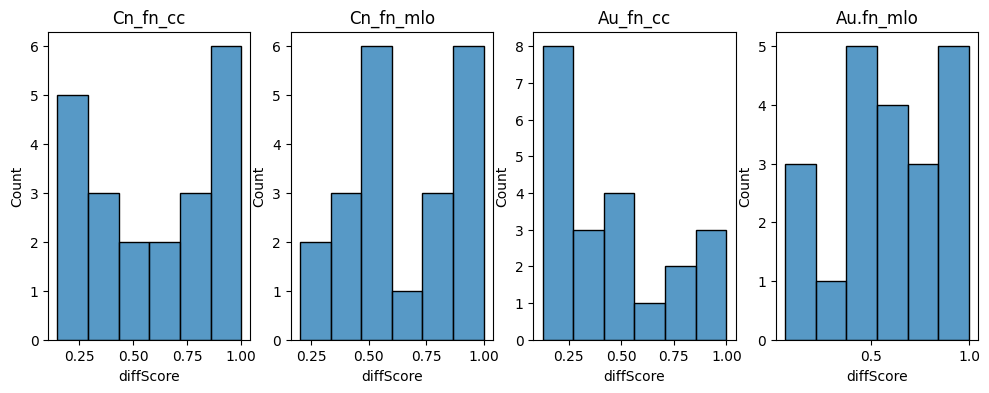

In [ ]:
fig, axs = pyplot.subplots(1,4,figsize=(12, 4))
path = 'drive/MyDrive/ML models/Cn_fn_feat_CC.xlsx'
X,y = get_fn_data(path)
sns.histplot(y, ax=axs[0]).set(title='Cn_fn_cc')
path1 = 'drive/MyDrive/ML models/Cn_fn_feat_MLO.xlsx'
X1,y1 = get_fn_data(path1)
sns.histplot(y1,ax=axs[1]).set(title='Cn_fn_mlo')
path2 = 'drive/MyDrive/ML models/Au_fn_feat_CC.xlsx'
X2,y2 = get_fn_data(path2)
sns.histplot(y2, ax=axs[2]).set(title='Au_fn_cc')
path3 = 'drive/MyDrive/ML models/Au_fn_feat_MLO.xlsx'
X3,y3 = get_fn_data(path3)
sns.histplot(y3,ax=axs[3]).set(title='Au.fn_mlo')

In [ ]:
path = 'drive/MyDrive/ML models/Cn_fn_feat_CC.xlsx'
path1 = 'drive/MyDrive/ML models/Cn_fn_feat_MLO.xlsx'
X,y = get_fn_data(path)
X1,y1 = get_fn_data(path1)
Y = pd.concat([y,y1])
np.percentile(Y,[0,50,100])


array([0.15, 0.6 , 1.  ])

In [ ]:
path2 = 'drive/MyDrive/ML models/Au_fn_feat_CC.xlsx'
X2,y2 = get_fn_data(path2)
path3 = 'drive/MyDrive/ML models/Au_fn_feat_MLO.xlsx'
X3,y3 = get_fn_data(path3)
Y = pd.concat([y2,y3])
np.percentile(Y,[0,50,100])

array([0.0625 , 0.46875, 1.     ])

#### Exporing models

##### Regression models (RandomForestRegressor)

In [ ]:
Path = []
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO.xlsx')
for ii in range(0,4):
  path = Path[ii]
  X,y = get_fn_data(path)
  print(X.shape)

(20, 202)
(20, 202)
(20, 202)
(20, 202)


In [ ]:
Path=[]
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO.xlsx')
for i in range(0,4):
  path = Path[i]
  X,y = get_fn_data(path)
  cv_outer = LeaveOneOut()
  outer_results = []
  y_true = []
  for train_ix, test_ix in cv_outer.split(X):
    X_train,X_test = X[train_ix,:], X[test_ix,:]
    y_train,y_test = y[train_ix],y[test_ix]
    model = RandomForestRegressor(max_features=0.33,n_jobs=-1,random_state=4)
    pipe = Pipeline([('s', StandardScaler()),
                    ('var',VarianceThreshold(threshold=1)),
                    ('model',model)])
    space = dict()
    space['model__n_estimators']= [100,250,500]
    space['model__max_samples']=[0.1,0.5,1.0]

    cv_inner = RepeatedKFold(n_splits=2, n_repeats=3, random_state=4)
    search = GridSearchCV(pipe, space, scoring='neg_mean_absolute_error', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    best_model = result.best_estimator_
    yhat = best_model.predict(X_test)
    outer_results.append(yhat[0])
    y_true.append(y_test.to_list()[0])
    # report progress
    #print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
  error = mean_absolute_error(y_true,outer_results)
  cor = pearsonr(y_true, outer_results)
  print('The results for ',path,'is below:')
  print('mean absolute error is :',error)
  print('pearson correlation is :',cor)

The results for  drive/MyDrive/ML models/Cn_fn_feat_CC.xlsx is below:
mean absolute error is : 0.25533333333333347
pearson correlation is : (0.251785758039894, 0.27088227345358507)
The results for  drive/MyDrive/ML models/Cn_fn_feat_MLO.xlsx is below:
mean absolute error is : 0.2175238095238099
pearson correlation is : (-0.0835813884824487, 0.7187006627877442)
The results for  drive/MyDrive/ML models/Au_fn_feat_CC.xlsx is below:
mean absolute error is : 0.25547619047619047
pearson correlation is : (0.08589978645256978, 0.7112157387986806)
The results for  drive/MyDrive/ML models/Au_fn_feat_MLO.xlsx is below:
mean absolute error is : 0.24683928571428573
pearson correlation is : (-0.34584988000774497, 0.1246179561368378)


#### qcut(3)

In [ ]:
# explore how qcut(3) divide the diffScores
path='drive/MyDrive/ML models/Cn_fn_feat_CC.xlsx'
data = pd.read_excel(path)
data = data.loc[data.lesionnumber!=2,:]
d = data.copy()
d['p'] = pd.qcut(d.diffScore,3,[0,3,1])
#d.loc[d['p']==0,:]
#d.loc[d['p']==1,:]
#d.loc[d['p']==3,:]

In [ ]:
def get_qua_fn_data(path):
  data = pd.read_excel(path)
  data = data.loc[data.lesionnumber!=2,:]
  d = data.copy()
  d['p'] = pd.qcut(d.diffScore,3,[0,3,1])
  d_drop = pd.concat([d[d['p']==0],d[d['p']==1]],axis = 0)
  X = d_drop.loc[:,'featROI_fn_  1':'featROI_fn_202']
  X = X.to_numpy()
  y = d_drop.p.to_numpy().reshape(-1,1)
  over = SMOTE(sampling_strategy="minority",random_state=2)
  X,y = over.fit_resample(X,y)
  return X,y


In [ ]:
Path = []
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO.xlsx')
for ii in range(0,4):
  path = Path[ii]
  X,y = get_qua_fn_data(path)
  print(X.shape)

(14, 202)
(14, 202)
(16, 202)
(16, 202)


In [ ]:
Path = []
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO.xlsx')

for ii in range(0,4):
  path = Path[ii]
  X,y = get_qua_fn_data(path)
  cv_outer = LeaveOneOut()
  y_true,y_pred,Predicted_class  = list(),list(),list()
  for train_ix, test_ix in cv_outer.split(X):
    X_train,X_test = X[train_ix,:], X[test_ix,:]
    y_train,y_test = y[train_ix],y[test_ix]
    clf = RandomForestClassifier(criterion='entropy',max_features='sqrt',n_jobs=-1, random_state=4)
    space = {"model__n_estimators": [100,250,500]}
    pipeline = Pipeline([('s', StandardScaler()),
                    ('var',VarianceThreshold(threshold=1)),
                    ('model',clf)])
    cv_inner = RepeatedKFold(n_splits=2, n_repeats=3, random_state=4)
    search = GridSearchCV(pipeline, space, scoring='roc_auc', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    best_model = result.best_estimator_
    yhat_proba = best_model.predict_proba(X_test)[:,1]

    y_pred.append(yhat_proba[0])
    Predicted_class.append(best_model.predict(X_test))
    y_true.append(y_test[0])

    # report progress
    #print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))

  auc = roc_auc_score(y_true, y_pred)
  accuracy = accuracy_score(y_true,Predicted_class)
  print('The results for ',path,'is below:')
  print('auc: %.3f' % auc)
  print("Accuracy: ", accuracy)

The results for  drive/MyDrive/ML models/Cn_fn_feat_CC.xlsx is below:
auc: 0.510
Accuracy:  0.6428571428571429
The results for  drive/MyDrive/ML models/Cn_fn_feat_MLO.xlsx is below:
auc: 0.612
Accuracy:  0.5
The results for  drive/MyDrive/ML models/Au_fn_feat_CC.xlsx is below:
auc: 0.594
Accuracy:  0.5625
The results for  drive/MyDrive/ML models/Au_fn_feat_MLO.xlsx is below:
auc: 0.750
Accuracy:  0.5625


#### 2 cut 25% q

In [ ]:
# explore the division using 25%
path='drive/MyDrive/ML models/Au_fn_feat_MLO.xlsx'
data = pd.read_excel(path)
# data = data.loc[data.lesionnumber!=2,:]
d = data.copy()
bins = [0,d.diffScore.quantile(q=0.5),d.diffScore.max()]
d['p'] = pd.cut(d.diffScore,bins,labels=[0,1])

d.loc[d['p']==0,:]
# d.loc[d['p']==1,:]

,CaseName,lesionnumber,view_View_View,LesionTypes,Rads,Cluster,Centroid_X,Centroid_Y,BoundingBox_x,BoundingBox_y,...,featROI_fn_196,featROI_fn_197,featROI_fn_198,featROI_fn_199,featROI_fn_200,featROI_fn_201,featROI_fn_202,featROI_fn_203,diffScore,p
0,GCAC,1,LMLO,Stellate,15.0,1.0,608.747826,2702.705294,446.409276,2558.024410,...,15.463036,33.817283,12.612799,27.394653,64096.264241,62655.984048,-0.260695,NaN,0.0625,0
1,GCAN,1,LMLO,Architectural distortion,9.0,1.0,1021.395390,2284.759961,910.314890,2142.109032,...,14.390855,32.644727,11.319694,25.190077,61998.045491,60586.139307,-0.264242,NaN,0.4375,0
2,GCAT,1,LMLO,Stellate,10.0,1.0,963.925764,1773.871338,854.326282,1654.208299,...,17.954121,41.184721,14.501568,31.688044,69226.018676,67533.248257,-0.212396,NaN,0.3750,0
5,GCBG,1,RMLO,Calcifications,13.0,1.0,3984.252202,2344.952797,3829.720911,2222.092758,...,17.543089,52.340801,15.453263,36.923488,74966.100569,73228.397287,-0.170433,NaN,0.1875,0
6,GCBI,1,RMLO,Non specific density (NSD),7.0,1.0,4113.189610,3832.109690,3949.696501,3773.777055,...,19.835225,39.958764,16.120082,34.638983,90082.033644,88274.646424,-0.224449,NaN,0.5625,0
9,GCBU,1,LMLO,Calcifications,7.0,1.0,1048.305195,2082.818834,910.314890,1982.141579,...,19.671346,43.867839,15.826750,34.375028,91740.193651,89943.735306,-0.133857,NaN,0.5625,0
11,GCCA,1,RMLO,Discrete mass,9.0,1.0,3967.568658,3554.238774,3861.714402,3485.835639,...,10.780426,32.364610,8.984368,21.164911,67665.860532,66229.137944,-0.435887,NaN,0.4375,0
12,GCCG,1,LMLO,Stellate,14.0,1.0,751.085480,2291.710970,590.379984,2126.112286,...,18.669704,48.029349,15.563395,35.995800,64313.346514,62772.574877,-0.228147,NaN,0.1250,0
15,MAC,1,LMLO,Discrete mass,9.0,1.0,493.102515,1303.968772,449.852471,1260.032703,...,19.405326,35.430576,14.737231,30.958802,48735.549195,47439.374579,-0.338577,NaN,0.4375,0
17,MAT,1,RMLO,Stellate,11.0,1.0,1140.345336,1195.115897,1096.707122,1186.678052,...,21.264303,38.977615,15.381739,32.078570,55432.595421,50139.859368,-0.284565,NaN,0.3125,0


In [ ]:
def get_fourth_fn_data(path):
  data = pd.read_excel(path)
  data = data.loc[data.lesionnumber!=2,:]
  d = data.copy()
  bins = [0,d.diffScore.quantile(q=0.25),d.diffScore.max()]
  d['p'] = pd.cut(d.diffScore,bins,labels=[0,1])
  X = d.loc[:,'featROI_fn_  1':'featROI_fn_202']
  X = X.to_numpy()
  y = d.p.to_numpy().reshape(-1,1)
  # over = SMOTE(sampling_strategy="minority",random_state=2,k_neighbors=4)
  # X,y = over.fit_resample(X,y)
  return X,y

In [ ]:
Path = []
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO.xlsx')

for ii in range(0,4):
  path = Path[ii]
  X,y = get_fourth_fn_data(path)
  cv_outer = LeaveOneOut()
  y_true,y_pred,Predicted_class  = list(),list(),list()
  for train_ix, test_ix in cv_outer.split(X):
    X_train,X_test = X[train_ix,:], X[test_ix,:]
    y_train,y_test = y[train_ix],y[test_ix]
    clf = RandomForestClassifier(criterion='entropy',max_features='sqrt',n_jobs=-1, random_state=4,class_weight='balanced')
    pipeline = Pipeline([('s', StandardScaler()),
                    ('var',VarianceThreshold(threshold=1)),
                    ('model',clf)])
    space = {"model__n_estimators": [100,250,500,1000]}
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    search = GridSearchCV(pipeline, space, scoring='roc_auc', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    best_model = result.best_estimator_
    yhat_proba = best_model.predict_proba(X_test)[:,1]
    y_pred.append(yhat_proba[0])
    Predicted_class.append(best_model.predict(X_test))
    y_true.append(y_test[0])

  auc = roc_auc_score(y_true, y_pred)
  accuracy = accuracy_score(y_true,Predicted_class)
  print('The results for ',path,'is below:')
  print('auc: %.3f' % auc)
  print("Accuracy: ", accuracy)
  # check the important features
  Dict = {}
  for key in sorted(features):
      for num in features[key]:
          if num not in Dict:
              Dict[num] = 1
          else:
              Dict[num]+=1
  KEY = []
  for key in sorted(Dict):
    print(key,':',Dict[key])

  print('The top 5 frequently selected features',sorted(Dict, key=Dict.get, reverse=True)[:5])


The results for  drive/MyDrive/ML models/Cn_fn_feat_CC.xlsx is below:
auc: 0.280
Accuracy:  0.7
The results for  drive/MyDrive/ML models/Cn_fn_feat_MLO.xlsx is below:
auc: 0.587
Accuracy:  0.7
The results for  drive/MyDrive/ML models/Au_fn_feat_CC.xlsx is below:
auc: 0.493
Accuracy:  0.7
The results for  drive/MyDrive/ML models/Au_fn_feat_MLO.xlsx is below:
auc: 0.587
Accuracy:  0.7


#### 2 cut median division

In [ ]:
def get_med_fn_data(path):
  data = pd.read_excel(path)
  # data = data.loc[data.lesionnumber!=2,:]
  d = data.copy()
  bins = [0,d.diffScore.quantile(q=0.5),d.diffScore.max()]
  d['p'] = pd.cut(d.diffScore,bins,labels=[0,1])
  X = d.loc[:,'featROI_fn_  1':'featROI_fn_202']
  X = X.to_numpy()
  y = d.p.to_numpy().reshape(-1,1)
  return X,y


In [ ]:
path = 'drive/MyDrive/ML models/Cn_fn_feat_CC.xlsx'
X,y = get_med_fn_data(path)

cv_outer = LeaveOneOut()
features = dict()
Yhat_proba,Yhat = list(),list()
Y_true = []
Best_inner_score = []
row = 0
for train_ix, test_ix in cv_outer.split(X):
  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1, random_state=4,class_weight='balanced_subsample')
  pipeline = Pipeline([('s', StandardScaler()),
                     ('var',VarianceThreshold(threshold=1)),
                     #('pca',PCA(0.95)),
                     ('model',clf)])
  space = {"model__n_estimators": [100,250,500,1000]}

  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipeline, space, scoring='roc_auc',n_jobs = -1, cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train.ravel())
  best_model = result.best_estimator_
  yhat_proba = best_model.predict_proba(X_test)[:,1]
  Yhat_proba.append(yhat_proba[0])
  yhat = best_model.predict(X_test)
  Yhat.append(yhat[0])
  Y_true.append(y_test[0])

  print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
  Best_inner_score.append(result.best_score_)

  feature_names = result.best_estimator_.named_steps['var'].get_support(indices=True)
  print('The number of remained feautes after variance check: ', len(feature_names))
  # print(feature_names)
  result_importance = result.best_estimator_.named_steps['model'].feature_importances_
  forest_importances = pd.Series(result_importance, index=feature_names)
  Feats = np.argsort(forest_importances)[::-1][:10]
  features[row] = Feats
  row+=1

# Calculate roc_auc on the hold out dataset
AUC_score = roc_auc_score(Y_true, Yhat_proba)
Accuracy = accuracy_score(Y_true,Yhat)
print('auc: %.3f' % AUC_score)
print("Accuracy: ", Accuracy)
print('precision', precision_score(Y_true,Yhat))
print("recall",recall_score(Y_true,Yhat))
print('f1 metrics',f1_score(Y_true,Yhat))
print('The average best inner score is {}, the standard deviation of the scores is {}'.format(mean(Best_inner_score), std(Best_inner_score)))
print(Y_true)
print(Yhat)

cm1 = confusion_matrix(Y_true,Yhat)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

# check the important features
Dict = {}
for key in sorted(features):
    for num in features[key]:
        if num not in Dict:
            Dict[num] = 1
        else:
            Dict[num]+=1
KEY = []
for key in sorted(Dict):
  print(key,':',Dict[key])

print('The top 5 frequently selected features',sorted(Dict, key=Dict.get, reverse=True)[:5])

>est=0.639, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  60
>est=0.639, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  66
>est=0.639, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  62
>est=0.778, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  78
>est=0.741, cfg={'model__n_estimators': 1000}
The number of remained feautes after variance check:  74
>est=0.722, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  72
>est=0.806, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  69
>est=0.843, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  71
>est=0.815, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  77
>est=0.750, cfg={'model__n_estimators': 100}
The number of remained feautes after

In [ ]:
n_bootstraps = 2000
rng_seed =24  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(Yhat_proba), len(Yhat_proba))
    if len(np.unique(np.array(Y_true)[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(np.array(Y_true)[indices], np.array(Yhat_proba)[indices])
    bootstrapped_scores.append(score)
#     print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.418 - 0.923]


In [ ]:
path = 'drive/MyDrive/ML models/Cn_fn_feat_MLO.xlsx'
X,y = get_med_fn_data(path)

cv_outer = LeaveOneOut()
features = dict()
Yhat_proba,Yhat = list(),list()
Y_true = []
Best_inner_score = []
row = 0
for train_ix, test_ix in cv_outer.split(X):
  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1, random_state=4,class_weight='balanced_subsample')
  pipeline = Pipeline([('s', StandardScaler()),
                     ('var',VarianceThreshold(threshold=1)),
                     #('pca',PCA(0.95)),
                     ('model',clf)])
  space = {"model__n_estimators": [100,250,500,1000]}

  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipeline, space, scoring='roc_auc',n_jobs = -1, cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train.ravel())
  best_model = result.best_estimator_
  yhat_proba = best_model.predict_proba(X_test)[:,1]
  Yhat_proba.append(yhat_proba[0])
  yhat = best_model.predict(X_test)
  Yhat.append(yhat[0])
  Y_true.append(y_test[0])

  print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
  Best_inner_score.append(result.best_score_)

  feature_names = result.best_estimator_.named_steps['var'].get_support(indices=True)
  print('The number of remained feautes after variance check: ', len(feature_names))
  # print(feature_names)
  result_importance = result.best_estimator_.named_steps['model'].feature_importances_
  forest_importances = pd.Series(result_importance, index=feature_names)
  Feats = np.argsort(forest_importances)[::-1][:10]
  features[row] = Feats
  row+=1

# Calculate roc_auc on the hold out dataset
AUC_score = roc_auc_score(Y_true, Yhat_proba)
Accuracy = accuracy_score(Y_true,Yhat)
print('auc: %.3f' % AUC_score)
print("Accuracy: ", Accuracy)
print('precision', precision_score(Y_true,Yhat))
print("recall",recall_score(Y_true,Yhat))
print('f1 metrics',f1_score(Y_true,Yhat))
print('The average best inner score is {}, the standard deviation of the scores is {}'.format(mean(Best_inner_score), std(Best_inner_score)))
print(Y_true)
print(Yhat)

cm1 = confusion_matrix(Y_true,Yhat)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

# check the important features
Dict = {}
for key in sorted(features):
    for num in features[key]:
        if num not in Dict:
            Dict[num] = 1
        else:
            Dict[num]+=1
KEY = []
for key in sorted(Dict):
  print(key,':',Dict[key])

print('The top 5 frequently selected features',sorted(Dict, key=Dict.get, reverse=True)[:5])

>est=0.861, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  71
>est=0.796, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  71
>est=0.722, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  65
>est=0.551, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  75
>est=0.736, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  72
>est=0.796, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  59
>est=0.796, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  63
>est=0.796, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  71
>est=0.713, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  75
>est=0.657, cfg={'model__n_estimators': 100}
The number of remained feautes after 

In [ ]:
n_bootstraps = 2000
rng_seed =50  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(Yhat_proba), len(Yhat_proba))
    if len(np.unique(np.array(Y_true)[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(np.array(Y_true)[indices], np.array(Yhat_proba)[indices])
    bootstrapped_scores.append(score)
#     print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.407 - 0.907]


In [ ]:
path = 'drive/MyDrive/ML models/Au_fn_feat_CC.xlsx'
Au_fn_cc = pd.read_excel(path)
Au_fn_cc

,CaseName,lesionnumber,view_View_View,LesionTypes,Rads,Cluster,Centroid_X,Centroid_Y,BoundingBox_x,BoundingBox_y,...,featROI_fn_195,featROI_fn_196,featROI_fn_197,featROI_fn_198,featROI_fn_199,featROI_fn_200,featROI_fn_201,featROI_fn_202,featROI_fn_203,diffScore
0,GCAC,1,LCC,Stellate,13.0,1.0,415.442446,3054.123538,230.453214,2941.946298,...,14.302134,18.650922,41.056069,15.222712,33.522102,43172.269531,42129.000288,-0.250801,NaN,0.1875
1,GCAN,1,LCC,Architectural distortion,9.0,1.0,595.140729,2747.060399,502.397884,2630.009764,...,11.183662,15.132625,34.546010,12.223295,27.279561,44877.713835,43838.463279,-0.356757,NaN,0.4375
2,GCAT,1,LCC,Stellate,14.0,1.0,683.027228,2584.387812,590.379984,2470.042311,...,12.525189,16.456235,38.836728,13.434881,29.581791,62769.221388,61215.607003,-0.213144,NaN,0.1250
3,GCBE,1,RCC,Stellate,10.0,2.0,4135.684054,2317.163636,4029.680228,2214.094386,...,13.556685,18.453710,39.687668,14.872521,32.804184,62610.889048,61058.337411,-0.312868,NaN,0.3750
4,GCBG,2,LCC,Discrete mass,NaN,NaN,NaN,NaN,NaN,NaN,...,11.447361,16.213978,32.279821,12.866846,27.690782,57942.562966,56379.806588,-0.257820,NaN,1.0000
5,GCBG,1,RCC,Calcifications,13.0,1.0,4207.055426,2094.078419,4077.670464,1958.146461,...,15.373140,18.983289,47.394707,15.694116,35.306479,57132.882977,55555.603233,-0.101115,NaN,0.1875
6,GCBI,1,RCC,Non specific density (NSD),11.0,1.0,4148.255512,2915.717456,4013.683483,2837.967453,...,13.079551,18.609089,36.562796,14.839470,32.159852,55535.004104,53956.434871,-0.268542,NaN,0.3125
7,GCBM,1,RCC,Stellate,4.0,1.0,4095.969298,3614.761628,3989.688365,3549.822620,...,15.078364,20.495916,44.257385,16.428247,35.576489,56145.191399,54705.567689,-0.250062,NaN,0.7500
8,GCBR,1,RCC,Stellate | Non specific density (NSD),12.0,1.0,4279.178958,2825.269650,4101.665582,2606.014646,...,12.829427,17.070526,38.317208,13.751448,30.611912,69307.064151,67741.318832,-0.175492,NaN,0.2500
9,GCBU,1,LCC,Calcifications,8.0,1.0,643.209123,1536.151698,486.401139,1462.247356,...,14.964438,19.580189,45.146910,15.944157,35.239510,62640.887610,60957.068556,-0.090627,NaN,0.5000


In [ ]:
path = 'drive/MyDrive/ML models/Au_fn_feat_CC.xlsx'
X,y = get_med_fn_data(path)

cv_outer = LeaveOneOut()
features = dict()
Yhat_proba,Yhat = list(),list()
Y_true = []
Best_inner_score = []
row = 0
for train_ix, test_ix in cv_outer.split(X):
  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1, random_state=4)
  pipeline = Pipeline([('s', StandardScaler()),
                     ('var',VarianceThreshold(threshold=1)),
                     #('pca',PCA(0.95)),
                     ('model',clf)])
  space = {"model__n_estimators": [100,250,500,1000]}

  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipeline, space, scoring='roc_auc',n_jobs = -1, cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train.ravel())
  best_model = result.best_estimator_
  yhat_proba = best_model.predict_proba(X_test)[:,1]
  Yhat_proba.append(yhat_proba[0])
  yhat = best_model.predict(X_test)
  Yhat.append(yhat[0])
  Y_true.append(y_test[0])

  print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
  Best_inner_score.append(result.best_score_)

  feature_names = result.best_estimator_.named_steps['var'].get_support(indices=True)
  print('The number of remained feautes after variance check: ', len(feature_names))
  # print(feature_names)
  result_importance = result.best_estimator_.named_steps['model'].feature_importances_
  forest_importances = pd.Series(result_importance, index=feature_names)
  Feats = np.argsort(forest_importances)[::-1][:10]
  features[row] = Feats
  row+=1

print("Y_true",Y_true)
print("Yhat_proba",Yhat_proba)
# Calculate roc_auc on the hold out dataset
AUC_score = roc_auc_score(Y_true, Yhat_proba)
Accuracy = accuracy_score(Y_true,Yhat)
print('auc: %.3f' % AUC_score)
print("Accuracy: ", Accuracy)
print('precision', precision_score(Y_true,Yhat))
print("recall",recall_score(Y_true,Yhat))
print('f1 metrics',f1_score(Y_true,Yhat))
print('The average best inner score is {}, the standard deviation of the scores is {}'.format(mean(Best_inner_score), std(Best_inner_score)))
print(Y_true)
print(Yhat)

cm1 = confusion_matrix(Y_true,Yhat)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

# check the important features
Dict = {}
for key in sorted(features):
    for num in features[key]:
        if num not in Dict:
            Dict[num] = 1
        else:
            Dict[num]+=1
KEY = []
for key in sorted(Dict):
  print(key,':',Dict[key])

print('The top 5 frequently selected features',sorted(Dict, key=Dict.get, reverse=True)[:5])

>est=0.694, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  60
>est=0.694, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  66
>est=0.722, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  62
>est=0.694, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  78
>est=0.542, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  74
>est=0.778, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  72
>est=0.778, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  69
>est=0.796, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  71
>est=0.630, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  77
>est=0.759, cfg={'model__n_estimators': 1000}
The number of remained feautes after

In [ ]:
n_bootstraps = 2000
rng_seed =42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(Yhat_proba), len(Yhat_proba))
    if len(np.unique(np.array(Y_true)[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(np.array(Y_true)[indices], np.array(Yhat_proba)[indices])
    bootstrapped_scores.append(score)
#     print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.286 - 0.9]


In [ ]:
path = 'drive/MyDrive/ML models/Au_fn_feat_MLO.xlsx'
X,y = get_med_fn_data(path)

cv_outer = LeaveOneOut()
features = dict()
Yhat_proba,Yhat = list(),list()
Y_true = []
Best_inner_score = []
row = 0
for train_ix, test_ix in cv_outer.split(X):
  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1, random_state=4)
  pipeline = Pipeline([('s', StandardScaler()),
                     ('var',VarianceThreshold(threshold=1)),
                     ('model',clf)])
  space = {"model__n_estimators": [100,250,500,1000]}

  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipeline, space, scoring='roc_auc',n_jobs = -1, cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train.ravel())
  best_model = result.best_estimator_
  yhat_proba = best_model.predict_proba(X_test)[:,1]
  Yhat_proba.append(yhat_proba[0])
  yhat = best_model.predict(X_test)
  Yhat.append(yhat[0])
  Y_true.append(y_test[0])

  print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
  Best_inner_score.append(result.best_score_)

  feature_names = result.best_estimator_.named_steps['var'].get_support(indices=True)
  print('The number of remained feautes after variance check: ', len(feature_names))
  # print(feature_names)
  # result_importance = result.best_estimator_.named_steps['model'].feature_importances_
  # forest_importances = pd.Series(result_importance, index=feature_names)
  # Feats = np.argsort(forest_importances)[::-1][:10]
  # features[row] = Feats
  # row+=1

# Calculate roc_auc on the hold out dataset
AUC_score = roc_auc_score(Y_true, Yhat_proba)
Accuracy = accuracy_score(Y_true,Yhat)
print('auc: %.3f' % AUC_score)
print("Accuracy: ", Accuracy)
print('precision', precision_score(Y_true,Yhat))
print("recall",recall_score(Y_true,Yhat))
print('f1 metrics',f1_score(Y_true,Yhat))
print('The average best inner score is {}, the standard deviation of the scores is {}'.format(mean(Best_inner_score), std(Best_inner_score)))
print(Y_true)
print(Yhat)

cm1 = confusion_matrix(Y_true,Yhat)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

# check the important features
Dict = {}
for key in sorted(features):
    for num in features[key]:
        if num not in Dict:
            Dict[num] = 1
        else:
            Dict[num]+=1
KEY = []
for key in sorted(Dict):
  print(key,':',Dict[key])

print('The top 5 frequently selected features',sorted(Dict, key=Dict.get, reverse=True)[:5])

>est=0.574, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  71
>est=0.648, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  71
>est=0.597, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  65
>est=0.444, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  75
>est=0.694, cfg={'model__n_estimators': 1000}
The number of remained feautes after variance check:  72
>est=0.537, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  59
>est=0.602, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  63
>est=0.722, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  71
>est=0.602, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  75
>est=0.537, cfg={'model__n_estimators': 1000}
The number of remained feautes afte

In [ ]:
n_bootstraps = 2000
rng_seed =50  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(Yhat_proba), len(Yhat_proba))
    if len(np.unique(np.array(Y_true)[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(np.array(Y_true)[indices], np.array(Yhat_proba)[indices])
    bootstrapped_scores.append(score)
#     print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.235 - 0.773]


#### 75% percentile

In [ ]:
def get_75_fn_data(path):
  data = pd.read_excel(path)
  # data = data.loc[data.lesionnumber!=2,:]
  d = data.copy()
  bins = [0,d.diffScore.quantile(q=0.75),d.diffScore.max()]
  d['p'] = pd.cut(d.diffScore,bins,labels=[0,1])
  X = d.loc[:,'featROI_fn_  1':'featROI_fn_202']
  X = X.to_numpy()
  y = d.p.to_numpy().reshape(-1,1)
  return X,y

In [ ]:
path = 'drive/MyDrive/ML models/Cn_fn_feat_CC.xlsx'
X,y = get_75_fn_data(path)

cv_outer = LeaveOneOut()
features = dict()
Yhat_proba,Yhat = list(),list()
Y_true = []
Best_inner_score = []
row = 0
for train_ix, test_ix in cv_outer.split(X):
  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1, random_state=4,class_weight='balanced_subsample')
  pipeline = Pipeline([('s', StandardScaler()),
                     ('var',VarianceThreshold(threshold=1)),
                     #('pca',PCA(0.95)),
                     ('model',clf)])
  space = {"model__n_estimators": [100,250,500,1000]}

  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipeline, space, scoring='roc_auc',n_jobs = -1, cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train.ravel())
  best_model = result.best_estimator_
  yhat_proba = best_model.predict_proba(X_test)[:,1]
  Yhat_proba.append(yhat_proba[0])
  yhat = best_model.predict(X_test)
  Yhat.append(yhat[0])
  Y_true.append(y_test[0])

  print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
  Best_inner_score.append(result.best_score_)

  feature_names = result.best_estimator_.named_steps['var'].get_support(indices=True)
  print('The number of remained feautes after variance check: ', len(feature_names))
  # print(feature_names)
  result_importance = result.best_estimator_.named_steps['model'].feature_importances_
  forest_importances = pd.Series(result_importance, index=feature_names)
  Feats = np.argsort(forest_importances)[::-1][:10]
  features[row] = Feats
  row+=1

# Calculate roc_auc on the hold out dataset
AUC_score = roc_auc_score(Y_true, Yhat_proba)
Accuracy = accuracy_score(Y_true,Yhat)
print('auc: %.3f' % AUC_score)
print("Accuracy: ", Accuracy)
print('precision', precision_score(Y_true,Yhat))
print("recall",recall_score(Y_true,Yhat))
print('f1 metrics',f1_score(Y_true,Yhat))
print('The average best inner score is {}, the standard deviation of the scores is {}'.format(mean(Best_inner_score), std(Best_inner_score)))
print(Y_true)
print(Yhat)

cm1 = confusion_matrix(Y_true,Yhat)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

# check the important features
Dict = {}
for key in sorted(features):
    for num in features[key]:
        if num not in Dict:
            Dict[num] = 1
        else:
            Dict[num]+=1
KEY = []
for key in sorted(Dict):
  print(key,':',Dict[key])

print('The top 5 frequently selected features',sorted(Dict, key=Dict.get, reverse=True)[:5])

>est=0.833, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  60
>est=0.667, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  66
>est=0.611, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  62
>est=0.667, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  78
>est=nan, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  74
>est=0.628, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  72
>est=0.722, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  69
>est=0.667, cfg={'model__n_estimators': 1000}
The number of remained feautes after variance check:  71
>est=0.889, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  77
>est=0.600, cfg={'model__n_estimators': 250}
The number of remained feautes after v

In [ ]:
path = 'drive/MyDrive/ML models/Cn_fn_feat_MLO.xlsx'
X,y = get_75_fn_data(path)

cv_outer = LeaveOneOut()
features = dict()
Yhat_proba,Yhat = list(),list()
Y_true = []
Best_inner_score = []
row = 0
for train_ix, test_ix in cv_outer.split(X):
  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1, random_state=4,class_weight='balanced_subsample')
  pipeline = Pipeline([('s', StandardScaler()),
                     ('var',VarianceThreshold(threshold=1)),
                     #('pca',PCA(0.95)),
                     ('model',clf)])
  space = {"model__n_estimators": [100,250,500,1000]}

  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipeline, space, scoring='roc_auc',n_jobs = -1, cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train.ravel())
  best_model = result.best_estimator_
  yhat_proba = best_model.predict_proba(X_test)[:,1]
  Yhat_proba.append(yhat_proba[0])
  yhat = best_model.predict(X_test)
  Yhat.append(yhat[0])
  Y_true.append(y_test[0])

  print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
  Best_inner_score.append(result.best_score_)

  feature_names = result.best_estimator_.named_steps['var'].get_support(indices=True)
  print('The number of remained feautes after variance check: ', len(feature_names))
  # print(feature_names)
  result_importance = result.best_estimator_.named_steps['model'].feature_importances_
  forest_importances = pd.Series(result_importance, index=feature_names)
  Feats = np.argsort(forest_importances)[::-1][:10]
  features[row] = Feats
  row+=1

# Calculate roc_auc on the hold out dataset
AUC_score = roc_auc_score(Y_true, Yhat_proba)
Accuracy = accuracy_score(Y_true,Yhat)
print('auc: %.3f' % AUC_score)
print("Accuracy: ", Accuracy)
print('precision', precision_score(Y_true,Yhat))
print("recall",recall_score(Y_true,Yhat))
print('f1 metrics',f1_score(Y_true,Yhat))
print('The average best inner score is {}, the standard deviation of the scores is {}'.format(mean(Best_inner_score), std(Best_inner_score)))
print(Y_true)
print(Yhat)

cm1 = confusion_matrix(Y_true,Yhat)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

# check the important features
Dict = {}
for key in sorted(features):
    for num in features[key]:
        if num not in Dict:
            Dict[num] = 1
        else:
            Dict[num]+=1
KEY = []
for key in sorted(Dict):
  print(key,':',Dict[key])

print('The top 5 frequently selected features',sorted(Dict, key=Dict.get, reverse=True)[:5])

>est=0.500, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  71
>est=0.522, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  71
>est=0.456, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  65
>est=0.400, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  75
>est=0.472, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  72
>est=0.489, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  59
>est=0.600, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  63
>est=0.744, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  71
>est=0.617, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  75
>est=0.561, cfg={'model__n_estimators': 100}
The number of remained feautes after 

In [ ]:
path = 'drive/MyDrive/ML models/Au_fn_feat_CC.xlsx'
X,y = get_75_fn_data(path)

cv_outer = LeaveOneOut()
features = dict()
Yhat_proba,Yhat = list(),list()
Y_true = []
Best_inner_score = []
row = 0
for train_ix, test_ix in cv_outer.split(X):
  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1, random_state=4,class_weight='balanced_subsample')
  pipeline = Pipeline([('s', StandardScaler()),
                     ('var',VarianceThreshold(threshold=1)),
                     #('pca',PCA(0.95)),
                     ('model',clf)])
  space = {"model__n_estimators": [100,250,500,1000]}

  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipeline, space, scoring='roc_auc',n_jobs = -1, cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train.ravel())
  best_model = result.best_estimator_
  yhat_proba = best_model.predict_proba(X_test)[:,1]
  Yhat_proba.append(yhat_proba[0])
  yhat = best_model.predict(X_test)
  Yhat.append(yhat[0])
  Y_true.append(y_test[0])

  print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
  Best_inner_score.append(result.best_score_)

  feature_names = result.best_estimator_.named_steps['var'].get_support(indices=True)
  print('The number of remained feautes after variance check: ', len(feature_names))
  # print(feature_names)
  result_importance = result.best_estimator_.named_steps['model'].feature_importances_
  forest_importances = pd.Series(result_importance, index=feature_names)
  Feats = np.argsort(forest_importances)[::-1][:10]
  features[row] = Feats
  row+=1

# Calculate roc_auc on the hold out dataset
AUC_score = roc_auc_score(Y_true, Yhat_proba)
Accuracy = accuracy_score(Y_true,Yhat)
print('auc: %.3f' % AUC_score)
print("Accuracy: ", Accuracy)
print('precision', precision_score(Y_true,Yhat))
print("recall",recall_score(Y_true,Yhat))
print('f1 metrics',f1_score(Y_true,Yhat))
print('The average best inner score is {}, the standard deviation of the scores is {}'.format(mean(Best_inner_score), std(Best_inner_score)))
print(Y_true)
print(Yhat)

cm1 = confusion_matrix(Y_true,Yhat)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

# check the important features
Dict = {}
for key in sorted(features):
    for num in features[key]:
        if num not in Dict:
            Dict[num] = 1
        else:
            Dict[num]+=1
KEY = []
for key in sorted(Dict):
  print(key,':',Dict[key])

print('The top 5 frequently selected features',sorted(Dict, key=Dict.get, reverse=True)[:5])

>est=0.650, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  60
>est=0.633, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  66
>est=0.633, cfg={'model__n_estimators': 1000}
The number of remained feautes after variance check:  62
>est=0.667, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  78
>est=0.356, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  74
>est=0.700, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  72
>est=0.733, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  69
>est=0.561, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  71
>est=0.733, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  77
>est=0.717, cfg={'model__n_estimators': 250}
The number of remained feautes after

In [ ]:
path = 'drive/MyDrive/ML models/Au_fn_feat_MLO.xlsx'
X,y = get_75_fn_data(path)

cv_outer = LeaveOneOut()
features = dict()
Yhat_proba,Yhat = list(),list()
Y_true = []
Best_inner_score = []
row = 0
for train_ix, test_ix in cv_outer.split(X):
  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1, random_state=4,class_weight='balanced_subsample')
  pipeline = Pipeline([('s', StandardScaler()),
                     ('var',VarianceThreshold(threshold=1)),
                     #('pca',PCA(0.95)),
                     ('model',clf)])
  space = {"model__n_estimators": [100,250,500,1000]}

  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipeline, space, scoring='roc_auc',n_jobs = -1, cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train.ravel())
  best_model = result.best_estimator_
  yhat_proba = best_model.predict_proba(X_test)[:,1]
  Yhat_proba.append(yhat_proba[0])
  yhat = best_model.predict(X_test)
  Yhat.append(yhat[0])
  Y_true.append(y_test[0])

  print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
  Best_inner_score.append(result.best_score_)

  feature_names = result.best_estimator_.named_steps['var'].get_support(indices=True)
  print('The number of remained feautes after variance check: ', len(feature_names))
  # print(feature_names)
  result_importance = result.best_estimator_.named_steps['model'].feature_importances_
  forest_importances = pd.Series(result_importance, index=feature_names)
  Feats = np.argsort(forest_importances)[::-1][:10]
  features[row] = Feats
  row+=1

# Calculate roc_auc on the hold out dataset
AUC_score = roc_auc_score(Y_true, Yhat_proba)
Accuracy = accuracy_score(Y_true,Yhat)
print('auc: %.3f' % AUC_score)
print("Accuracy: ", Accuracy)
print('precision', precision_score(Y_true,Yhat))
print("recall",recall_score(Y_true,Yhat))
print('f1 metrics',f1_score(Y_true,Yhat))
print('The average best inner score is {}, the standard deviation of the scores is {}'.format(mean(Best_inner_score), std(Best_inner_score)))
print(Y_true)
print(Yhat)

cm1 = confusion_matrix(Y_true,Yhat)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

# check the important features
Dict = {}
for key in sorted(features):
    for num in features[key]:
        if num not in Dict:
            Dict[num] = 1
        else:
            Dict[num]+=1
KEY = []
for key in sorted(Dict):
  print(key,':',Dict[key])

print('The top 5 frequently selected features',sorted(Dict, key=Dict.get, reverse=True)[:5])

>est=0.700, cfg={'model__n_estimators': 1000}
The number of remained feautes after variance check:  71
>est=0.633, cfg={'model__n_estimators': 1000}
The number of remained feautes after variance check:  71
>est=0.400, cfg={'model__n_estimators': 1000}
The number of remained feautes after variance check:  65
>est=0.611, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  75
>est=0.300, cfg={'model__n_estimators': 500}
The number of remained feautes after variance check:  72
>est=0.300, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  59
>est=0.300, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  63
>est=0.500, cfg={'model__n_estimators': 250}
The number of remained feautes after variance check:  71
>est=0.600, cfg={'model__n_estimators': 100}
The number of remained feautes after variance check:  75
>est=0.400, cfg={'model__n_estimators': 100}
The number of remained feautes aft

### False nagative margin

#### Regression model

In [ ]:
def get_fn_data_margin(path):
  data = pd.read_excel(path)
  data = data.loc[data.lesionnumber!=2,:]
  y = data.diffScore
  X = data.loc[:,'featROI_fn_  1':'featROI_fn_202']
  X.dropna(axis=1,inplace=True)
  X = X.to_numpy()
  return X,y

In [ ]:
Path=[]
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC_margin.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO_margin.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC_margin.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO_margin.xlsx')
for i in range(0,4):
  path = Path[i]
  X,y = get_fn_data_margin(path)
  print(X.shape)

(21, 196)
(21, 196)
(21, 196)
(21, 196)


In [ ]:
Path=[]
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC_margin.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO_margin.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC_margin.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO_margin.xlsx')
for i in range(0,4):
  path = Path[i]
  X,y = get_fn_data_margin(path)
  cv_outer = LeaveOneOut()
  outer_results = []
  y_true = []
  for train_ix, test_ix in cv_outer.split(X):
    X_train,X_test = X[train_ix,:], X[test_ix,:]
    y_train,y_test = y[train_ix],y[test_ix]
    model = RandomForestRegressor(max_features=0.33,n_jobs=-1,random_state=4)
    pipe = Pipeline([('s', StandardScaler()),
                    ('var',VarianceThreshold(threshold=1)),
                    ('model',model)])
    space = dict()
    space['model__n_estimators']= [100,250,500]
    space['model__max_samples']=[0.1,0.5,1.0]

    cv_inner = KFold(n_splits=3, shuffle=True, random_state=4)
    search = GridSearchCV(pipe, space, scoring='neg_mean_absolute_error', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    best_model = result.best_estimator_
    yhat = best_model.predict(X_test)
    outer_results.append(yhat[0])
    y_true.append(y_test.to_list()[0])
    # report progress
    #print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
  error = mean_absolute_error(y_true,outer_results)
  cor = pearsonr(y_true, outer_results)
  print('The results for ',path,'is below:')
  print('mean absolute error is :',error)
  print('pearson correlation is :',cor)

The results for  drive/MyDrive/ML models/Cn_fn_feat_CC_margin.xlsx is below:
mean absolute error is : 0.20834285714285708
pearson correlation is : (0.6553681421898876, 0.0012601143472752215)
The results for  drive/MyDrive/ML models/Cn_fn_feat_MLO_margin.xlsx is below:
mean absolute error is : 0.18295238095238098
pearson correlation is : (0.40484580541846976, 0.06868486195000574)
The results for  drive/MyDrive/ML models/Au_fn_feat_CC_margin.xlsx is below:
mean absolute error is : 0.2675892857142857
pearson correlation is : (0.151547875717155, 0.5119794467270112)
The results for  drive/MyDrive/ML models/Au_fn_feat_MLO_margin.xlsx is below:
mean absolute error is : 0.23882142857142857
pearson correlation is : (0.07956833972041481, 0.7317151778215651)


#### qcut(3)

In [ ]:
def get_qua_fn_data_margin(path):
  data = pd.read_excel(path)
  data = data.loc[data.lesionnumber!=2,:]
  d = data.copy()
  d['p'] = pd.qcut(d.diffScore,3,[0,3,1])
  d_drop = pd.concat([d[d['p']==0],d[d['p']==1]],axis = 0)
  X = d_drop.loc[:,'featROI_fn_  1':'featROI_fn_202']
  X.dropna(axis=1,inplace=True)
  X = X.to_numpy()
  y = d_drop.p.to_numpy().reshape(-1,1)
  over = SMOTE(sampling_strategy="minority",random_state=2)
  X,y = over.fit_resample(X,y)
  return X,y

In [ ]:
Path=[]
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC_margin.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO_margin.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC_margin.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO_margin.xlsx')
for i in range(0,4):
  path = Path[i]
  X,y = get_qua_fn_data_margin(path)
  print(X.shape)

(14, 196)
(14, 196)
(16, 196)
(16, 196)


In [ ]:
X.shape

(22, 202)

In [ ]:
Path = []
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC_margin.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO_margin.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC_margin.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO_margin.xlsx')

for ii in range(0,4):
  path = Path[ii]
  X,y = get_qua_fn_data_margin(path)
  cv_outer = LeaveOneOut()
  y_true,y_pred,Predicted_class  = list(),list(),list()
  for train_ix, test_ix in cv_outer.split(X):
    X_train,X_test = X[train_ix,:], X[test_ix,:]
    y_train,y_test = y[train_ix],y[test_ix]
    clf = RandomForestClassifier(criterion='entropy',max_features='sqrt',n_jobs=-1, random_state=4)
    space = {"model__n_estimators": [100,250,500]}
    pipeline = Pipeline([('s', StandardScaler()),
                    ('var',VarianceThreshold(threshold=1)),
                    ('model',clf)])
    cv_inner = RepeatedKFold(n_splits=3, n_repeats=3, random_state=4)
    search = GridSearchCV(pipeline, space, scoring='roc_auc', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    best_model = result.best_estimator_
    yhat_proba = best_model.predict_proba(X_test)[:,1]

    y_pred.append(yhat_proba[0])
    Predicted_class.append(best_model.predict(X_test))
    y_true.append(y_test[0])

    # report progress
    #print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))

  auc = roc_auc_score(y_true, y_pred)
  accuracy = accuracy_score(y_true,Predicted_class)
  print('The results for ',path,'is below:')
  print('auc: %.3f' % auc)
  print("Accuracy: ", accuracy)

The results for  drive/MyDrive/ML models/Cn_fn_feat_CC_margin.xlsx is below:
auc: 1.000
Accuracy:  1.0
The results for  drive/MyDrive/ML models/Cn_fn_feat_MLO_margin.xlsx is below:
auc: 0.765
Accuracy:  0.6428571428571429
The results for  drive/MyDrive/ML models/Au_fn_feat_CC_margin.xlsx is below:
auc: 1.000
Accuracy:  1.0
The results for  drive/MyDrive/ML models/Au_fn_feat_MLO_margin.xlsx is below:
auc: 0.844
Accuracy:  0.75


#### 25%(2)

In [ ]:
def get_fourth_fn_data_margin(path):
  data = pd.read_excel(path)
  data = data.loc[data.lesionnumber!=2,:]
  d = data.copy()
  bins = [0,d.diffScore.quantile(q=0.25),d.diffScore.max()]
  d['p'] = pd.cut(d.diffScore,bins,labels=[0,1])
  X = d.loc[:,'featROI_fn_  1':'featROI_fn_202']
  X.dropna(axis=1,inplace=True)
  X = X.to_numpy()
  y = d.p.to_numpy().reshape(-1,1)
  over = SMOTE(sampling_strategy="minority",random_state=2)
  X,y = over.fit_resample(X,y)
  return X,y

In [ ]:
Path=[]
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC_margin.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO_margin.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC_margin.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO_margin.xlsx')
for i in range(0,4):
  path = Path[i]
  X,y = get_fourth_fn_data_margin(path)
  print(X.shape)

(28, 196)
(28, 196)
(26, 196)
(26, 196)


In [ ]:
Path = []
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC_margin.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO_margin.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC_margin.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO_margin.xlsx')

for ii in range(0,4):
  path = Path[ii]
  X,y = get_fourth_fn_data_margin(path)
  cv_outer = LeaveOneOut()
  y_true,y_pred,Predicted_class  = list(),list(),list()
  for train_ix, test_ix in cv_outer.split(X):
    X_train,X_test = X[train_ix,:], X[test_ix,:]
    y_train,y_test = y[train_ix],y[test_ix]
    clf = RandomForestClassifier(criterion='entropy',max_features='sqrt',n_jobs=-1, random_state=4)
    space = {"model__n_estimators": [100,250,500]}
    pipeline = Pipeline([('s', StandardScaler()),
                    ('var',VarianceThreshold(threshold=1)),
                    ('model',clf)])
    cv_inner = RepeatedKFold(n_splits=3, n_repeats=3, random_state=24)
    search = GridSearchCV(pipeline, space, scoring='roc_auc', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    best_model = result.best_estimator_
    yhat_proba = best_model.predict_proba(X_test)[:,1]

    y_pred.append(yhat_proba[0])
    Predicted_class.append(best_model.predict(X_test))
    y_true.append(y_test[0])

    # report progress
    #print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))

  auc = roc_auc_score(y_true, y_pred)
  accuracy = accuracy_score(y_true,Predicted_class)
  print('The results for ',path,'is below:')
  print('auc: %.3f' % auc)
  print("Accuracy: ", accuracy)

The results for  drive/MyDrive/ML models/Cn_fn_feat_CC_margin.xlsx is below:
auc: 0.893
Accuracy:  0.8571428571428571
The results for  drive/MyDrive/ML models/Cn_fn_feat_MLO_margin.xlsx is below:
auc: 0.804
Accuracy:  0.7857142857142857
The results for  drive/MyDrive/ML models/Au_fn_feat_CC_margin.xlsx is below:
auc: 0.772
Accuracy:  0.7692307692307693
The results for  drive/MyDrive/ML models/Au_fn_feat_MLO_margin.xlsx is below:
auc: 0.882
Accuracy:  0.8461538461538461


#### Median(2)

In [ ]:
def get_med_fn_data_margin(path):
  data = pd.read_excel(path)
  # data = data.loc[data.lesionnumber!=2,:]
  d = data.copy()
  bins = [0,d.diffScore.quantile(q=0.5),d.diffScore.max()]
  d['p'] = pd.cut(d.diffScore,bins,labels=[0,1])
  X = d.loc[:,'featROI_fn_  1':'featROI_fn_202']
  X.dropna(axis=1,inplace=True)
  X = X.to_numpy()
  y = d.p.to_numpy().reshape(-1,1)
  return X,y


In [ ]:
Path = []
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC_margin.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO_margin.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC_margin.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO_margin.xlsx')

for ii in range(0,4):
  path = Path[ii]
  X,y = get_med_fn_data_margin(path)
  cv_outer = LeaveOneOut()
  cv_outer = LeaveOneOut()
  y_true,y_pred,Predicted_class  = list(),list(),list()
  features=dict()
  row=0
  for train_ix, test_ix in cv_outer.split(X):
    X_train,X_test = X[train_ix,:], X[test_ix,:]
    y_train,y_test = y[train_ix],y[test_ix]
    clf = RandomForestClassifier(criterion='entropy',max_features='sqrt',n_jobs=-1, random_state=4,class_weight='balanced')
    pipeline = Pipeline([('s', StandardScaler()),
                    ('var',VarianceThreshold(threshold=1)),
                    ('model',clf)])
    space = {"model__n_estimators": [100,250,500,1000]}
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    search = GridSearchCV(pipeline, space, scoring='roc_auc', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    best_model = result.best_estimator_
    yhat_proba = best_model.predict_proba(X_test)[:,1]
    y_pred.append(yhat_proba[0])
    Predicted_class.append(best_model.predict(X_test))
    y_true.append(y_test[0])
    feature_names = result.best_estimator_.named_steps['var'].get_support(indices=True)
    result_importance = result.best_estimator_.named_steps['model'].feature_importances_
    forest_importances = pd.Series(result_importance, index=feature_names)
    Feats = np.argsort(forest_importances)[::-1][:10]
    features[row] = Feats
    row+=1


  auc = roc_auc_score(y_true, y_pred)
  accuracy = accuracy_score(y_true,Predicted_class)
  print('The results for ',path,'is below:')
  print('auc: %.3f' % auc)
  print("Accuracy: ", accuracy)
  # check the important features
  Dict = {}
  for key in sorted(features):
      for num in features[key]:
          if num not in Dict:
              Dict[num] = 1
          else:
              Dict[num]+=1
  # KEY = []
  # for key in sorted(Dict):
  #   print(key,':',Dict[key])

  print('The top 5 frequently selected features',sorted(Dict, key=Dict.get, reverse=True)[:5])

The results for  drive/MyDrive/ML models/Cn_fn_feat_CC_margin.xlsx is below:
auc: 0.736
Accuracy:  0.6666666666666666
The top 5 frequently selected features [43, 41, 44, 56, 46]
The results for  drive/MyDrive/ML models/Cn_fn_feat_MLO_margin.xlsx is below:
auc: 0.755
Accuracy:  0.7142857142857143
The top 5 frequently selected features [12, 10, 13, 61, 59]
The results for  drive/MyDrive/ML models/Au_fn_feat_CC_margin.xlsx is below:
auc: 0.473
Accuracy:  0.5714285714285714
The top 5 frequently selected features [6, 61, 7, 59, 60]
The results for  drive/MyDrive/ML models/Au_fn_feat_MLO_margin.xlsx is below:
auc: 0.691
Accuracy:  0.6666666666666666
The top 5 frequently selected features [50, 13, 38, 61, 28]


### False nagative directly from lesion (outer border) deleted

#### Regression model

In [ ]:
Path=[]
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC_direct.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO_direct.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC_direct.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO_direct.xlsx')
for i in range(0,4):
  path = Path[i]
  X,y = get_fn_data(path)
  cv_outer = LeaveOneOut()
  outer_results = []
  y_true = []
  for train_ix, test_ix in cv_outer.split(X):
    X_train,X_test = X[train_ix,:], X[test_ix,:]
    y_train,y_test = y[train_ix],y[test_ix]
    model = RandomForestRegressor(max_features=0.33,n_jobs=-1,random_state=4)
    pipe = Pipeline([('s', StandardScaler()),
                    ('var',VarianceThreshold(threshold=1)),
                    ('model',model)])
    space = dict()
    space['model__n_estimators']= [100,250,500]
    space['model__max_samples']=[0.1,0.5,1.0]

    cv_inner = KFold(n_splits=3, shuffle=True, random_state=4)
    search = GridSearchCV(pipe, space, scoring='neg_mean_absolute_error', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    best_model = result.best_estimator_
    yhat = best_model.predict(X_test)
    outer_results.append(yhat[0])
    y_true.append(y_test.to_list()[0])
    # report progress
    #print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
  error = mean_absolute_error(y_true,outer_results)
  cor = pearsonr(y_true, outer_results)
  print('The results for ',path,'is below:')
  print('mean absolute error is :',error)
  print('pearson correlation is :',cor)

The results for  drive/MyDrive/ML models/Cn_fn_feat_CC_direct.xlsx is below:
mean absolute error is : 0.20798095238095227
pearson correlation is : (0.5924961311597132, 0.004651677960302299)
The results for  drive/MyDrive/ML models/Cn_fn_feat_MLO_direct.xlsx is below:
mean absolute error is : 0.2032857142857143
pearson correlation is : (0.29813971850853827, 0.18929079478789781)
The results for  drive/MyDrive/ML models/Au_fn_feat_CC_direct.xlsx is below:
mean absolute error is : 0.2630119047619048
pearson correlation is : (-0.006326329119170304, 0.9782876102519587)
The results for  drive/MyDrive/ML models/Au_fn_feat_MLO_direct.xlsx is below:
mean absolute error is : 0.2534107142857143
pearson correlation is : (-0.3085576452010101, 0.17354907437978576)


#### qcut(3)

In [ ]:
Path = []
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC_direct.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO_direct.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC_direct.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO_direct.xlsx')

for ii in range(0,4):
  path = Path[ii]
  X,y = get_qua_fn_data(path)
  cv_outer = LeaveOneOut()
  y_true,y_pred,Predicted_class  = list(),list(),list()
  for train_ix, test_ix in cv_outer.split(X):
    X_train,X_test = X[train_ix,:], X[test_ix,:]
    y_train,y_test = y[train_ix],y[test_ix]
    clf = RandomForestClassifier(criterion='entropy',max_features='sqrt',n_jobs=-1, random_state=4)
    space = {"model__n_estimators": [100,250,500]}
    pipeline = Pipeline([('s', StandardScaler()),
                    ('var',VarianceThreshold(threshold=1)),
                    ('model',clf)])
    cv_inner = RepeatedKFold(n_splits=2, n_repeats=3, random_state=4)
    search = GridSearchCV(pipeline, space, scoring='roc_auc', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    best_model = result.best_estimator_
    yhat_proba = best_model.predict_proba(X_test)[:,1]

    y_pred.append(yhat_proba[0])
    Predicted_class.append(best_model.predict(X_test))
    y_true.append(y_test[0])

    # report progress
    #print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))

  auc = roc_auc_score(y_true, y_pred)
  accuracy = accuracy_score(y_true,Predicted_class)
  print('The results for ',path,'is below:')
  print('auc: %.3f' % auc)
  print("Accuracy: ", accuracy)

The results for  drive/MyDrive/ML models/Cn_fn_feat_CC_direct.xlsx is below:
auc: 0.857
Accuracy:  0.8571428571428571
The results for  drive/MyDrive/ML models/Cn_fn_feat_MLO_direct.xlsx is below:
auc: 0.735
Accuracy:  0.6428571428571429
The results for  drive/MyDrive/ML models/Au_fn_feat_CC_direct.xlsx is below:
auc: 0.812
Accuracy:  0.8125
The results for  drive/MyDrive/ML models/Au_fn_feat_MLO_direct.xlsx is below:
auc: 0.625
Accuracy:  0.625


#### 25%(2 parts)

In [ ]:
Path = []
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC_direct.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO_direct.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC_direct.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO_direct.xlsx')

for ii in range(0,4):
  path = Path[ii]
  X,y = get_fourth_fn_data(path)
  cv_outer = LeaveOneOut()
  y_true,y_pred,Predicted_class  = list(),list(),list()
  for train_ix, test_ix in cv_outer.split(X):
    X_train,X_test = X[train_ix,:], X[test_ix,:]
    y_train,y_test = y[train_ix],y[test_ix]
    clf = RandomForestClassifier(criterion='entropy',max_features='sqrt',n_jobs=-1, random_state=4)
    space = {"model__n_estimators": [100,250,500]}
    pipeline = Pipeline([('s', StandardScaler()),
                    ('var',VarianceThreshold(threshold=1)),
                    ('model',clf)])
    cv_inner = RepeatedKFold(n_splits=2, n_repeats=3, random_state=4)
    search = GridSearchCV(pipeline, space, scoring='roc_auc', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    best_model = result.best_estimator_
    yhat_proba = best_model.predict_proba(X_test)[:,1]

    y_pred.append(yhat_proba[0])
    Predicted_class.append(best_model.predict(X_test))
    y_true.append(y_test[0])

    # report progress
    #print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))

  auc = roc_auc_score(y_true, y_pred)
  accuracy = accuracy_score(y_true,Predicted_class)
  print('The results for ',path,'is below:')
  print('auc: %.3f' % auc)
  print("Accuracy: ", accuracy)

The results for  drive/MyDrive/ML models/Cn_fn_feat_CC_direct.xlsx is below:
auc: 0.839
Accuracy:  0.8214285714285714
The results for  drive/MyDrive/ML models/Cn_fn_feat_MLO_direct.xlsx is below:
auc: 0.635
Accuracy:  0.6785714285714286
The results for  drive/MyDrive/ML models/Au_fn_feat_CC_direct.xlsx is below:
auc: 0.781
Accuracy:  0.8076923076923077
The results for  drive/MyDrive/ML models/Au_fn_feat_MLO_direct.xlsx is below:
auc: 0.675
Accuracy:  0.6538461538461539


#### Median (2 parts)

In [ ]:
Path = []
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC_direct.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO_direct.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC_direct.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO_direct.xlsx')

for ii in range(0,4):
  path = Path[ii]
  X,y = get_med_fn_data(path)
  cv_outer = LeaveOneOut()
  y_true,y_pred,Predicted_class  = list(),list(),list()
  for train_ix, test_ix in cv_outer.split(X):
    X_train,X_test = X[train_ix,:], X[test_ix,:]
    y_train,y_test = y[train_ix],y[test_ix]
    clf = RandomForestClassifier(criterion='entropy',max_features='sqrt',n_jobs=-1, random_state=4)
    space = {"model__n_estimators": [100,250,500]}
    pipeline = Pipeline([('s', StandardScaler()),
                    ('var',VarianceThreshold(threshold=1)),
                    ('model',clf)])
    cv_inner = RepeatedKFold(n_splits=2, n_repeats=3, random_state=4)
    search = GridSearchCV(pipeline, space, scoring='roc_auc', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    best_model = result.best_estimator_
    yhat_proba = best_model.predict_proba(X_test)[:,1]

    y_pred.append(yhat_proba[0])
    Predicted_class.append(best_model.predict(X_test))
    y_true.append(y_test[0])

    # report progress
    #print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))

  auc = roc_auc_score(y_true, y_pred)
  accuracy = accuracy_score(y_true,Predicted_class)
  print('The results for ',path,'is below:')
  print('auc: %.3f' % auc)
  print("Accuracy: ", accuracy)

The results for  drive/MyDrive/ML models/Cn_fn_feat_CC_direct.xlsx is below:
auc: 0.802
Accuracy:  0.6818181818181818
The results for  drive/MyDrive/ML models/Cn_fn_feat_MLO_direct.xlsx is below:
auc: 0.831
Accuracy:  0.7272727272727273
The results for  drive/MyDrive/ML models/Au_fn_feat_CC_direct.xlsx is below:
auc: 0.587
Accuracy:  0.5909090909090909
The results for  drive/MyDrive/ML models/Au_fn_feat_MLO_direct.xlsx is below:
auc: 0.521
Accuracy:  0.5454545454545454


# Pearson Correlation - regression (deleted)
### Calculate AUC for regression

In [ ]:
path = 'drive/MyDrive/ML models/Cn_fp_CC.xlsx'
X,y = get_cn_data(path)
cv_outer = KFold(n_splits=10,shuffle=True,random_state=4)
outer_results = []
for train_ix, test_ix in cv_outer.split(X):

  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  model = RandomForestRegressor(max_features=0.33,n_jobs=-1,random_state=4, class_weight='balanced_subsample')
  pipe = Pipeline([('s', StandardScaler()),
                   ('var',VarianceThreshold(threshold=(.8 * (1 - .8)))),
                   ('model',model)])
  space = dict()
  space['model__n_estimators']= [100,250,500]
  space['model__max_samples']=[0.1,0.5,1.0]
  space['model__max_features']=[0.1,0.5,1.0]
  cv_inner = KFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipe, space, scoring='neg_mean_absolute_error', cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train)
  best_model = result.best_estimator_
  yhat = best_model.predict(X_test)
  error = mean_absolute_error(y_test, yhat)
  outer_results.append(error)
  print('y_test:', y_test.reshape(1,-1))
  print('y_pred:', yhat)
  # pearson correlation analysis
  pearson = pearsonr(y_test.reshape(-1,),yhat)
  print('r is {}, pvalue is {}'.format(pearson[0], pearson[1]))
  #print('95% CI:', pearson.confidence_interval())
  print('>error=%.3f, est=%.3f, cfg=%s' % (error, result.best_score_, result.best_params_))
  # add the classification step
  y_label=[]
  for i in range(len(y_test.squeeze())):
    if y_test.squeeze()[i] <= np.median(y_test):
      y_label.append(0)
    else:
      y_label.append(1)
  print('AUC is :',roc_auc_score(y_label,yhat) )

# summarize the estimated performance of the model
print('MAE: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

AttributeError: ignored

In [ ]:
path = 'drive/MyDrive/ML models/Cn_fp_MLO.xlsx'
X,y = get_cn_data(path)
cv_outer = KFold(n_splits=10,shuffle=True,random_state=4)
outer_results = []
AUC_ = []
for train_ix, test_ix in cv_outer.split(X):

  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  model = RandomForestRegressor(max_features=0.33,n_jobs=-1,random_state=4)
  pipe = Pipeline([('s', StandardScaler()),
                   ('var',VarianceThreshold(threshold=(.8 * (1 - .8)))),
                   ('model',model)])
  space = dict()
  space['model__n_estimators']= [100,250,500]
  space['model__max_samples']=[0.1,0.5,1.0]
  space['model__max_features']=[0.1,0.5,1.0]
  cv_inner = KFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipe, space, scoring='neg_mean_absolute_error', cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train)
  best_model = result.best_estimator_
  yhat = best_model.predict(X_test)
  error = mean_absolute_error(y_test, yhat)
  outer_results.append(error)
  print('y_test:', y_test.reshape(1,-1))
  print('y_pred:', yhat)
  # pearson correlation analysis
  pearson = pearsonr(y_test.reshape(-1,),yhat)
  print('r is {}, pvalue is {}'.format(pearson[0], pearson[1]))
  #print('95% CI:', pearson.confidence_interval())
  print('>error=%.3f, est=%.3f, cfg=%s' % (error, result.best_score_, result.best_params_))
  y_label=[]
  for i in range(len(y_test.squeeze())):
    if y_test.squeeze()[i] <= np.median(y_test):
      y_label.append(0)
    else:
      y_label.append(1)
  print('AUC is :',roc_auc_score(y_label,yhat))
  AUC_.append(roc_auc_score(y_label,yhat))
# summarize the estimated performance of the model
print('MAE: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))
print('Averaged AUC: ', mean(AUC_), std(AUC_))

y_test: [[0.05 0.1  0.15 0.05 0.4  0.05 0.1  0.05 0.05 0.05 0.15 0.05 0.05 0.05
  0.05 0.25]]
y_pred: [0.1148 0.1355 0.1584 0.1013 0.2377 0.0778 0.1678 0.0696 0.0768 0.1024
 0.1113 0.1329 0.0852 0.085  0.1145 0.1935]
r is 0.8743664136226748, pvalue is 9.443222090284393e-06
>error=0.052, est=-0.070, cfg={'model__max_features': 0.1, 'model__max_samples': 1.0, 'model__n_estimators': 500}
AUC is : 0.95
y_test: [[0.05 0.05 0.05 0.05 0.25 0.05 0.05 0.1  0.4  0.8  0.05 0.05 0.05 0.05
  0.15 0.1 ]]
y_pred: [0.0578 0.1131 0.0888 0.1082 0.241  0.0668 0.0819 0.1347 0.0912 0.0903
 0.1401 0.1289 0.0814 0.1064 0.159  0.0944]
r is 0.060239895442710994, pvalue is 0.8246146397766205
>error=0.097, est=-0.059, cfg={'model__max_features': 0.1, 'model__max_samples': 1.0, 'model__n_estimators': 500}
AUC is : 0.7333333333333334
y_test: [[0.1  0.05 0.1  0.1  0.05 0.4  0.15 0.05 0.2  0.3  0.05 0.1  0.05 0.05
  0.05 0.45]]
y_pred: [0.1168 0.0786 0.1306 0.1082 0.1494 0.2348 0.0622 0.1032 0.1512 0.0782
 0.0844 0.

In [ ]:
path = 'drive/MyDrive/ML models/Au_fp_CC.xlsx'
X,y = get_au_data(path)
cv_outer = KFold(n_splits=10,shuffle=True,random_state=4)
outer_results = []
for train_ix, test_ix in cv_outer.split(X):

  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  model = RandomForestRegressor(max_features=0.33,n_jobs=-1,random_state=4)
  pipe = Pipeline([('s', StandardScaler()),
                   ('var',VarianceThreshold(threshold=(.8 * (1 - .8)))),
                   ('model',model)])
  space = dict()
  space['model__n_estimators']= [100,250,500]
  space['model__max_samples']=[0.1,0.5,1.0]
  space['model__max_features']=[0.1,0.5,1.0]
  cv_inner = KFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipe, space, scoring='neg_mean_absolute_error', cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train)
  best_model = result.best_estimator_
  yhat = best_model.predict(X_test)
  error = mean_absolute_error(y_test, yhat)
  outer_results.append(error)
  print('y_test:', y_test.reshape(1,-1))
  print('y_pred:', yhat)
  # pearson correlation analysis
  pearson = pearsonr(y_test.reshape(-1,),yhat)
  print('r is {}, pvalue is {}'.format(pearson[0], pearson[1]))
  #print('95% CI:', pearson.confidence_interval())
  print('>error=%.3f, est=%.3f, cfg=%s' % (error, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

y_test: [[0.0625 0.0625 0.0625 0.3125 0.0625 0.25   0.0625 0.125  0.1875 0.0625
  0.0625]]
y_pred: [0.17575 0.11875 0.113   0.0675  0.09525 0.3025  0.084   0.13675 0.135
 0.14375 0.081  ]
r is 0.2804160769911098, pvalue is 0.4035920828680261
>error=0.067, est=-0.042, cfg={'model__max_features': 0.1, 'model__max_samples': 1.0, 'model__n_estimators': 250}
y_test: [[0.125  0.0625 0.0625 0.5    0.0625 0.0625 0.125  0.0625 0.1875 0.125
  0.0625]]
y_pred: [0.0875   0.0725   0.069375 0.200625 0.174375 0.119375 0.12875  0.083125
 0.070625 0.108125 0.080625]
r is 0.6195105605817975, pvalue is 0.042074703919682245
>error=0.064, est=-0.040, cfg={'model__max_features': 0.1, 'model__max_samples': 1.0, 'model__n_estimators': 100}
y_test: [[0.0625 0.0625 0.25   0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125
  0.0625]]
y_pred: [0.088625 0.104125 0.14275  0.101625 0.073    0.073375 0.076    0.131125
 0.0815   0.071625 0.08425 ]
r is 0.5621896810694725, pvalue is 0.07183920753704091
>error=0.037, est=-

In [ ]:
path = 'drive/MyDrive/ML models/Au_fp_MLO.xlsx'
X,y = get_au_data(path)
cv_outer = KFold(n_splits=10,shuffle=True,random_state=4)
outer_results = []
for train_ix, test_ix in cv_outer.split(X):

  X_train,X_test = X[train_ix,:], X[test_ix,:]
  y_train,y_test = y[train_ix],y[test_ix]
  model = RandomForestRegressor(max_features=0.33,n_jobs=-1,random_state=4)
  pipe = Pipeline([('s', StandardScaler()),
                   ('var',VarianceThreshold(threshold=(.8 * (1 - .8)))),
                   ('model',model)])
  space = dict()
  space['model__n_estimators']= [100,250,500]
  space['model__max_samples']=[0.1,0.5,1.0]
  space['model__max_features']=[0.1,0.5,1.0]
  cv_inner = KFold(n_splits=3, shuffle=True, random_state=4)
  search = GridSearchCV(pipe, space, scoring='neg_mean_absolute_error', cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train)
  best_model = result.best_estimator_
  yhat = best_model.predict(X_test)
  error = mean_absolute_error(y_test, yhat)
  outer_results.append(error)
  print('y_test:', y_test.reshape(1,-1))
  print('y_pred:', yhat)
  # pearson correlation analysis
  pearson = pearsonr(y_test.reshape(-1,),yhat)
  print('r is {}, pvalue is {}'.format(pearson[0], pearson[1]))
  #print('95% CI:', pearson.confidence_interval())
  print('>error=%.3f, est=%.3f, cfg=%s' % (error, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

y_test: [[0.0625 0.5    0.0625 0.0625 0.0625 0.1875 0.1875 0.0625 0.0625 0.0625
  0.0625]]
y_pred: [0.137125 0.098125 0.122125 0.10075  0.119625 0.162625 0.076625 0.085875
 0.08675  0.088125 0.081875]
r is 0.00995907279169992, pvalue is 0.976815875411563
>error=0.078, est=-0.039, cfg={'model__max_features': 0.5, 'model__max_samples': 0.1, 'model__n_estimators': 500}
y_test: [[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125  0.0625 0.0625 0.0625
  0.0625]]
y_pred: [0.14125  0.079375 0.080625 0.144375 0.086875 0.083125 0.075625 0.074375
 0.103125 0.0875   0.081875]
r is -0.24725240795984468, pvalue is 0.4635602758457981
>error=0.035, est=-0.046, cfg={'model__max_features': 0.1, 'model__max_samples': 0.5, 'model__n_estimators': 100}
y_test: [[0.125  0.0625 0.0625 0.0625 0.0625 0.125  0.125  0.0625 0.0625 0.0625
  0.1875]]
y_pred: [0.090375 0.0895   0.103    0.118375 0.09     0.0845   0.080375 0.083875
 0.08375  0.081    0.09025 ]
r is -0.2147026008884315, pvalue is 0.5260963648173028
>err

### 2 parts median division

In [ ]:
Path = []
Path.append('drive/MyDrive/ML models/Cn_fn_feat_CC.xlsx')
Path.append('drive/MyDrive/ML models/Cn_fn_feat_MLO.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_CC.xlsx')
Path.append('drive/MyDrive/ML models/Au_fn_feat_MLO.xlsx')

for ii in range(0,4):
  path = Path[ii]
  X,y = get_med_fn_data(path)
  cv_outer = LeaveOneOut()
  y_true,y_pred,Predicted_class  = list(),list(),list()
  for train_ix, test_ix in cv_outer.split(X):
    X_train,X_test = X[train_ix,:], X[test_ix,:]
    y_train,y_test = y[train_ix],y[test_ix]
    clf = RandomForestClassifier(criterion='entropy',max_features='sqrt',n_jobs=-1, random_state=4)
    space = {"model__n_estimators": [100,250,500]}
    pipeline = Pipeline([('s', StandardScaler()),
                    ('var',VarianceThreshold(threshold=1)),
                    ('model',clf)])
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=4)
    search = GridSearchCV(pipeline, space, scoring='roc_auc', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    best_model = result.best_estimator_
    yhat_proba = best_model.predict_proba(X_test)[:,1]

    y_pred.append(yhat_proba[0])
    Predicted_class.append(best_model.predict(X_test))
    y_true.append(y_test[0])

    # report progress
    #print('>est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))

  auc = roc_auc_score(y_true, y_pred)
  accuracy = accuracy_score(y_true,Predicted_class)
  print('The results for ',path,'is below:')
  print('auc: %.3f' % auc)
  print("Accuracy: ", accuracy)

### Exporing models

>RF 0.838 (0.062)
>GB 0.819 (0.072)


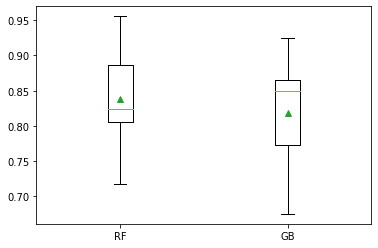

In [ ]:
path = 'drive/MyDrive/ML models/Cn_fp_CC.xlsx'
X,y = get_cn_data(path)
clfs = get_classifier()
names,results = list(),list()
for name, clf in clfs.items():
    scores = evaluate_clf(clf,X,y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>RF 0.878 (0.071)
>GB 0.864 (0.077)


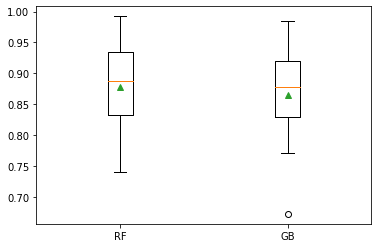

In [ ]:
path = 'drive/MyDrive/ML models/Cn_fp_MLO.xlsx'
X,y = get_cn_data(path)
clfs = get_classifier()
names,results = list(),list()
for name, clf in clfs.items():
    scores = evaluate_clf(clf,X,y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>RF 0.896 (0.042)
>GB 0.886 (0.049)


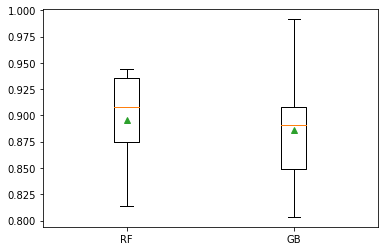

In [ ]:
path = 'drive/MyDrive/ML models/Au_fp_CC.xlsx'
X,y = get_au_data(path)
clfs = get_classifier()
names,results = list(),list()
for name, clf in clfs.items():
    scores = evaluate_clf(clf,X,y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>RF 0.873 (0.070)
>GB 0.851 (0.084)


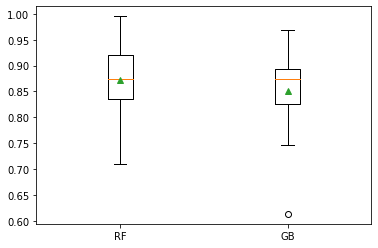

In [ ]:
path = 'drive/MyDrive/ML models/Au_fp_MLO.xlsx'
X,y = get_au_data(path)
clfs = get_classifier()
names,results = list(),list()
for name, clf in clfs.items():
    scores = evaluate_clf(clf,X,y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
# get dataset (done previously)
# get model (done previously: RF & GB)
# define data prep pipeline (below in this cell)
def get_pipeline(model):
    pipelines= []
    pipe1 = Pipeline([('s', StandardScaler()),
                     ('var',VarianceThreshold(threshold=1)),
                     ('pca',PCA(0.95)),
                     ('model',model)]) #(scaler, variance, PCA, model)
    pipelines.append(('pipe1_pca',pipe1))

    pipe2 = Pipeline([('s', StandardScaler()),
                     ('var',VarianceThreshold(threshold=1)),
                     ('model',model)]) # (scaler, variance, selectFromRF, model)
    pipelines.append(('pipe2_non',pipe2))
    return pipelines

under pipe1_pca pipeline, the results are below:
[0.6875 0.75   0.875  0.75   0.625 ]
0.7375 0.082915619758885
_________________________________________________________
under pipe2_non pipeline, the results are below:
[0.8125 0.75   0.6875 0.6875 0.75  ]
0.7375 0.046770717334674264
_________________________________________________________


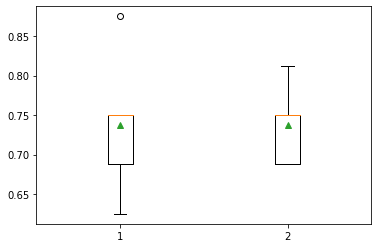

In [ ]:
# Advanced radiomics model (scaler, variance, PCA, model)
path = 'drive/MyDrive/ML models/Cn_fp_CC_exclude.xlsx'
X,y = get_cn_data(path)

cv_outer = KFold(n_splits=4,shuffle=True,random_state=4)
cv_inner = KFold(n_splits=3,shuffle=True,random_state=4)

clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1, random_state=4)
search_space = {"model__n_estimators": [100,250,500,1000]}

pipelines = get_pipeline(clf)
pipe_name,test_score = list(),list()
for name,pipeline in pipelines:
    search = GridSearchCV(pipeline, search_space, cv=cv_inner, scoring='roc_auc',n_jobs=-1, refit=True)
    scores = cross_val_score(search,X,y,scoring='roc_auc',cv=cv_outer,n_jobs=-1)
    print("under {} pipeline, the results are below:".format(name))
    print(scores)
    print(mean(scores), std(scores))
    print("_________________________________________________________")

    pipe_name.append(name)
    test_score.append(scores)
pyplot.boxplot(test_score, showmeans=True)
pyplot.show()

under pipe1_pca pipeline, the results are below:
[0.875      1.         0.68055556 0.64285714]
0.7996031746031745 0.1454176940558474
_________________________________________________________
under pipe2_non pipeline, the results are below:
[0.79166667 0.86666667 0.72222222 0.35714286]
0.6844246031746032 0.19573900427555205
_________________________________________________________


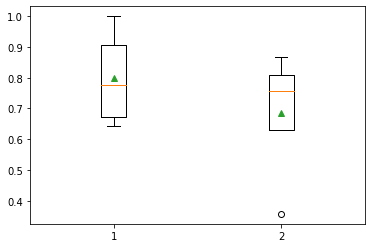

In [ ]:
path = 'drive/MyDrive/ML models/Cn_fp_MLO_exclude.xlsx'
X,y = get_cn_data(path)
cv_outer = KFold(n_splits=4,shuffle=True,random_state=24)
cv_inner = KFold(n_splits=3,shuffle=True,random_state=24)
clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1, random_state=4)
search_space = {"model__n_estimators": [100,250,500,1000]}

pipelines = get_pipeline(clf)
pipe_name,test_score = list(),list()
for name,pipeline in pipelines:
    search = GridSearchCV(pipeline, search_space, cv=cv_inner, scoring='roc_auc',n_jobs=-1, refit=True)
    scores = cross_val_score(search,X,y,scoring='roc_auc',cv=cv_outer,n_jobs=-1)
    print("under {} pipeline, the results are below:".format(name))
    print(scores)
    print(mean(scores), std(scores))
    print("_________________________________________________________")

    pipe_name.append(name)
    test_score.append(scores)
pyplot.boxplot(test_score, showmeans=True)
pyplot.show()

under pipe1_pca pipeline, the results are below:
[0.33333333 0.         0.75       0.75      ]
0.45833333333333337 0.3145764348029479
_________________________________________________________
under pipe2_non pipeline, the results are below:
[0.5        0.33333333 0.75       0.75      ]
0.5833333333333333 0.1767766952966369
_________________________________________________________


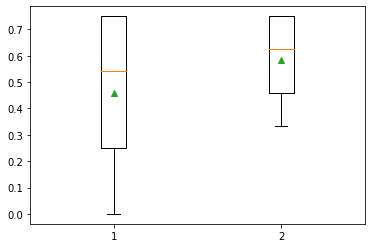

In [ ]:
path = 'drive/MyDrive/ML models/Au_fp_CC_exclude.xlsx'
X,y = get_au_data(path)

cv_outer = KFold(n_splits=4,shuffle=True,random_state=24)
cv_inner = KFold(n_splits=3,shuffle=True,random_state=24)
clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1, random_state=4)
search_space = {"model__n_estimators": [100,250,500,1000]}

pipelines = get_pipeline(clf)
pipe_name,test_score = list(),list()
for name,pipeline in pipelines:
    search = GridSearchCV(pipeline, search_space, cv=cv_inner, scoring='roc_auc',n_jobs=-1, refit=True)
    scores = cross_val_score(search,X,y,scoring='roc_auc',cv=cv_outer,n_jobs=-1)
    print("under {} pipeline, the results are below:".format(name))
    print(scores)
    print(mean(scores), std(scores))
    print("_________________________________________________________")

    pipe_name.append(name)
    test_score.append(scores)
pyplot.boxplot(test_score, showmeans=True)
pyplot.show()

under pipe1_pca pipeline, the results are below:
[0.625      0.88888889 1.         0.5       ]
0.7534722222222222 0.19991679403451085
_________________________________________________________
under pipe2_non pipeline, the results are below:
[0.75       1.         0.75       0.33333333]
0.7083333333333334 0.23935677693908453
_________________________________________________________


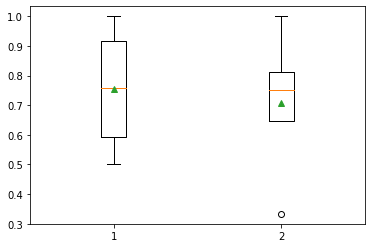

In [ ]:
path = 'drive/MyDrive/ML models/Au_fp_MLO_exclude.xlsx'
X,y = get_au_data(path)
cv_outer = KFold(n_splits=4,shuffle=True,random_state=24)
cv_inner = KFold(n_splits=3,shuffle=True,random_state=24)
clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1, random_state=4)
search_space = {"model__n_estimators": [100,250,500,1000]}

pipelines = get_pipeline(clf)
pipe_name,test_score = list(),list()
for name,pipeline in pipelines:
    search = GridSearchCV(pipeline, search_space, cv=cv_inner, scoring='roc_auc',n_jobs=-1, refit=True)
    scores = cross_val_score(search,X,y,scoring='roc_auc',cv=cv_outer,n_jobs=-1)
    print("under {} pipeline, the results are below:".format(name))
    print(scores)
    print(mean(scores), std(scores))
    print("_________________________________________________________")

    pipe_name.append(name)
    test_score.append(scores)
pyplot.boxplot(test_score, showmeans=True)
pyplot.show()